# Part 0. Import Module

In [180]:
import sys, csv, json
import requests
from newsapi.articles import Articles
from newsapi.sources import Sources
import numpy as np
import csv, json
import pandas as pd
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
import math
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops

ImportError: No module named 'tf_utils'

# Part 1. Collect NYTimes data 

Newsapi documentation

https://github.com/SlapBot/newsapi

https://github.com/llSourcell/Stock_Market_Prediction/blob/master/Collecting%20NYTimes%20Data.py

In [16]:
key = '96af62a035db45bda517a9ca62a25ac3'

In [18]:
a = Articles(API_KEY=key)
s = Sources(API_KEY=key)

Creating 2 exception 

1 for API 

1 for Timeframe for the news 

In [19]:
class APIKeyException(Exception):
    def __init__(self, message): 
        self.message = message 

class InvalidQueryException(Exception):
    def __init__(self, message): 
        self.message = message     

Initializes the ArchiveAPI class to downlaod data to json file

Raises an exception if no API key is given.

param key: New York Times API Key

In [21]:
class ArchiveAPI(object):
    def __init__(self, key=None):
        self.key = key
        self.root = 'http://api.nytimes.com/svc/archive/v1/{}/{}.json?api-key={}' 
        if not self.key:
            nyt_dev_page = 'http://developer.nytimes.com/docs/reference/keys'
            exception_str = 'Warning: API Key required. Please visit {}'
            raise NoAPIKeyException(exception_str.format(nyt_dev_page))

    def query(self, year=None, month=None, key=None,):
        """
        Calls the archive API and returns the results as a dictionary.
        :param key: Defaults to the API key used to initialize the ArchiveAPI class.
        """
        if not key: 
            key = self.key
            
        if (year < 1882) or not (0 < month < 13):
            # currently the Archive API only supports year >= 1882
            exception_str = 'Invalid query: See http://developer.nytimes.com/archive_api.json'
            raise InvalidQueryException(exception_str)
            
        url = self.root.format(year, month, key)
        r = requests.get(url)
        return r.json()


api = ArchiveAPI('0ba6dc04a8cb44e0a890c00df88c393a')


years = [2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007]
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for year in years:
    for month in months:
        mydict = api.query(year, month)
        file_str = '/Users/user/Desktop/stock_rnn_data/' + str(year) + '-' + '{:02}'.format(month) + '.json'
        with open(file_str, 'w') as fout:
            try:
                json.dump(mydict, fout)
            except:
                pass
        fout.close()

# Part 2. Preparing Stock Price

Currently using a csv file, will use Quandl to download more and live data soon

In [68]:
with open('/Users/user/Desktop/stock_rnn_data/DJIA_indices_data.csv', 'r',encoding="utf-8") as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    # Converting the csv file reader to a lists 
    data_list = list(spamreader)

Separating header from the data

In [69]:
header = data_list[0] 
data_list = data_list[1:] 

data_list = np.asarray(data_list)

In [70]:
print(data_list)

[['2016-12-30' '19833.169922' '19852.550781' ..., '19762.599609'
  '271910000' '19762.599609']
 ['2016-12-29' '19835.460938' '19878.439453' ..., '19819.779297'
  '172040000' '19819.779297']
 ['2016-12-28' '19964.310547' '19981.109375' ..., '19833.679688'
  '188350000' '19833.679688']
 ..., 
 ['2007-01-04' '12473.160156' '12510.410156' ..., '12480.69043' '259060000'
  '12480.69043']
 ['2007-01-03' '12459.540039' '12580.349609' ..., '12474.519531'
  '327200000' '12474.519531']
 ['2006-12-29' '12500.480469' '12526.030273' ..., '12463.150391'
  '161560000' '12463.150391']]


Selecting date and close value and adj close for each day

volume will be added in the next model

In [71]:
selected_data = data_list[:, [0, 4, 6]]

Convert it into dataframe

index = date

In [72]:
df = pd.DataFrame(data=selected_data[0:,1:],
             index=selected_data[0:,0],
                                columns=['close', 'adj close'],
                                        dtype='float64')

In [73]:
print (df.tail())

                   close     adj close
2007-01-08  12423.490234  12423.490234
2007-01-05  12398.009766  12398.009766
2007-01-04  12480.690430  12480.690430
2007-01-03  12474.519531  12474.519531
2006-12-29  12463.150391  12463.150391


Interpolating data

In [99]:
df1 = df
idx = pd.date_range('12-29-2006', '12-31-2016')
df1.index = pd.DatetimeIndex(df1.index)
df1 = df1.reindex(idx, fill_value=np.NaN)
# df1.count() # gives 2518 count
interpolated_df = df1.interpolate() # Fill in the gap
interpolated_df.count() # gives 3651 count

close        3656
adj close    3656
dtype: int64

In [100]:
print (df1.head(25))

                   close     adj close
2006-12-29  12463.150391  12463.150391
2006-12-30           NaN           NaN
2006-12-31           NaN           NaN
2007-01-01           NaN           NaN
2007-01-02           NaN           NaN
2007-01-03  12474.519531  12474.519531
2007-01-04  12480.690430  12480.690430
2007-01-05  12398.009766  12398.009766
2007-01-06           NaN           NaN
2007-01-07           NaN           NaN
2007-01-08  12423.490234  12423.490234
2007-01-09  12416.599609  12416.599609
2007-01-10  12442.160156  12442.160156
2007-01-11  12514.980469  12514.980469
2007-01-12  12556.080078  12556.080078
2007-01-13           NaN           NaN
2007-01-14           NaN           NaN
2007-01-15           NaN           NaN
2007-01-16  12582.589844  12582.589844
2007-01-17  12577.150391  12577.150391
2007-01-18  12567.929688  12567.929688
2007-01-19  12565.530273  12565.530273
2007-01-20           NaN           NaN
2007-01-21           NaN           NaN
2007-01-22  12477.160156 

In [101]:
# Removing extra date rows added in data for calculating interpolation
interpolated_df = interpolated_df[3:]

In [102]:
print (interpolated_df.head())

                   close     adj close
2007-01-01  12469.971875  12469.971875
2007-01-02  12472.245703  12472.245703
2007-01-03  12474.519531  12474.519531
2007-01-04  12480.690430  12480.690430
2007-01-05  12398.009766  12398.009766


# Part 3. Merging NYTimes data

Function to parse and convert date format

Try 2 formats for date or raise error

In [103]:
date_format = ["%Y-%m-%dT%H:%M:%SZ", "%Y-%m-%dT%H:%M:%S+%f"]

def try_parsing_date(text):
    for fmt in date_format:
        try:
            return datetime.strptime(text, fmt).strftime('%Y-%m-%d')
        except ValueError:
            pass
    raise ValueError('no valid date format found')

In [104]:
years = [2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007]
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
dict_keys = ['pub_date', 'headline'] #, 'lead_paragraph']
articles_dict = dict.fromkeys(dict_keys)

Filtering to read only the following news

In [105]:
# Filtering list for type_of_material
type_of_material_list = ['blog', 'brief', 'news', 'editorial', 'op-ed', 'list','analysis']
# Filtering list for section_name
section_name_list = ['business', 'national', 'world', 'u.s.' , 'politics', 'opinion', 'tech', 'science',  'health']
news_desk_list = ['business', 'national', 'world', 'u.s.' , 'politics', 'opinion', 'tech', 'science',  'health', 'foreign']

In [106]:
current_date = '2016-10-01'
from datetime import datetime

current_article_str = ''     

Adding article column to dataframe

In [107]:
interpolated_df["articles"] = ''
count_articles_filtered = 0
count_total_articles = 0
count_main_not_exist = 0               
count_unicode_error = 0     
count_attribute_error = 0   

In [108]:
for year in years:  # search for every month
    for month in months:
        file_str = '/Users/user/Desktop/stock_rnn_data/' + str(year) + '-' + '{:02}'.format(month) + '.json'
        with open(file_str) as data_file:    
            NYTimes_data = json.load(data_file)
        count_total_articles = count_total_articles + len(NYTimes_data["response"]["docs"][:]) #add article number 
        for i in range(len(NYTimes_data["response"]["docs"][:])): # search in every docs for type of material or section = in the list
            try:
                if any(substring in NYTimes_data["response"]["docs"][:][i]['type_of_material'].lower() for substring in type_of_material_list):
                    if any(substring in NYTimes_data["response"]["docs"][:][i]['section_name'].lower() for substring in section_name_list):
                        #count += 1
                        count_articles_filtered += 1
                        #print 'i: ' + str(i) dick_key = ['pub_date', 'headline']
                        articles_dict = { your_key: NYTimes_data["response"]["docs"][:][i][your_key] for your_key in dict_keys }
                        articles_dict['headline'] = articles_dict['headline']['main'] # Selecting just 'main' from headline
                        #articles_dict['headline'] = articles_dict['lead_paragraph'] # Selecting lead_paragraph
                        date = try_parsing_date(articles_dict['pub_date'])
                        #print 'article_dict: ' + articles_dict['headline']
                        # putting same day article str into one str
                        if date == current_date:
                            current_article_str = current_article_str + '. ' + articles_dict['headline']
                        else:  
                            interpolated_df.set_value(current_date, 'articles', interpolated_df.loc[current_date, 'articles'] + '. ' + current_article_str)
                            current_date = date
                            #interpolated_df.set_value(date, 'articles', current_article_str)
                            #print str(date) + current_article_str
                            current_article_str = articles_dict['headline']
                        # For last condition in a year
                        if (date == current_date) and (i == len(NYTimes_data["response"]["docs"][:]) - 1): 
                            interpolated_df.set_value(date, 'articles', current_article_str)   
                        
             #Exception for section_name or type_of_material absent
            except AttributeError:
                #print 'attribute error'
                #print NYTimes_data["response"]["docs"][:][i]
                count_attribute_error += 1
                # If article matches news_desk_list if none section_name found
                try:
                    if any(substring in NYTimes_data["response"]["docs"][:][i]['news_desk'].lower() for substring in news_desk_list):
                            #count += 1
                            count_articles_filtered += 1
                            #print 'i: ' + str(i)
                            articles_dict = { your_key: NYTimes_data["response"]["docs"][:][i][your_key] for your_key in dict_keys }
                            articles_dict['headline'] = articles_dict['headline']['main'] # Selecting just 'main' from headline
                            #articles_dict['headline'] = articles_dict['lead_paragraph'] # Selecting lead_paragraph
                            date = try_parsing_date(articles_dict['pub_date'])
                            #print 'article_dict: ' + articles_dict['headline']
                            if date == current_date:
                                current_article_str = current_article_str + '. ' + articles_dict['headline']
                            else:  
                                interpolated_df.set_value(current_date, 'articles', interpolated_df.loc[current_date, 'articles'] + '. ' + current_article_str)
                                current_date = date
                                #interpolated_df.set_value(date, 'articles', current_article_str)
                                #print str(date) + current_article_str
                                current_article_str = articles_dict['headline']
                            # For last condition in a year
                            if (date == current_date) and (i == len(NYTimes_data["response"]["docs"][:]) - 1): 
                                interpolated_df.set_value(date, 'articles', current_article_str)   
                
                except AttributeError:
                    pass
                pass
            except KeyError:
                print ('key error')
                #print NYTimes_data["response"]["docs"][:][i]
                count_main_not_exist += 1
                pass   
            except TypeError:
                print ("type error")
                #print NYTimes_data["response"]["docs"][:][i]
                count_main_not_exist += 1
                pass

type error
key error
type error
key error
type error
type error
key error
type error
type error
key error
key error
key error
key error
key error
key error
type error


In [110]:
print (count_articles_filtered)
print (count_total_articles)                     
print (count_main_not_exist)
print (count_unicode_error)

461738
1248084
16
0


In [112]:
## Putting all articles if no section_name or news_desk not found
for date, row in interpolated_df.T.iteritems():   
    if len(interpolated_df.loc[date, 'articles']) <= 400:
        #print interpolated_df.loc[date, 'articles']
        #print date
        month = date.month
        year = date.year
        file_str = '/Users/user/Desktop/stock_rnn_data/' + str(year) + '-' + '{:02}'.format(month) + '.json'
        with open(file_str) as data_file:    
            NYTimes_data = json.load(data_file)
        count_total_articles = count_total_articles + len(NYTimes_data["response"]["docs"][:])
        interpolated_df.set_value(date.strftime('%Y-%m-%d'), 'articles', '')
        for i in range(len(NYTimes_data["response"]["docs"][:])):
            try:
                
                articles_dict = { your_key: NYTimes_data["response"]["docs"][:][i][your_key] for your_key in dict_keys }
                articles_dict['headline'] = articles_dict['headline']['main'] # Selecting just 'main' from headline
                #articles_dict['headline'] = articles_dict['lead_paragraph'] # Selecting lead_paragraph       
                pub_date = try_parsing_date(articles_dict['pub_date'])
                #print 'article_dict: ' + articles_dict['headline']
                if date.strftime('%Y-%m-%d') == pub_date: 
                    interpolated_df.set_value(pub_date, 'articles', interpolated_df.loc[pub_date, 'articles'] + '. ' + articles_dict['headline'])  
                
            except KeyError:
                print ('key error')
                #print NYTimes_data["response"]["docs"][:][i]
                #count_main_not_exist += 1
                pass   
            except TypeError:
                print ("type error")
                #print NYTimes_data["response"]["docs"][:][i]
                #count_main_not_exist += 1
                pass

type error
type error
type error
type error
type error
key error
type error
key error
key error
type error
type error
key error
key error


In [113]:

# Saving the data as pickle file
interpolated_df.to_pickle('/Users/user/Desktop/stock_rnn_data/pickled_ten_year_filtered_lead_para.pkl')  


# Save pandas frame in csv form
interpolated_df.to_csv('/Users/user/Desktop/stock_rnn_data/sample_interpolated_df_10_years_filtered_lead_para.csv',
                       sep='\t', encoding='utf-8')



# Reading the data as pickle file
dataframe_read = pd.read_pickle('/Users/user/Desktop/stock_rnn_data/pickled_ten_year_filtered_lead_para.pkl')




# Part 4. Deep Neural Network

start here 

In [121]:
df_stocks = pd.read_pickle('/Users/user/Desktop/stock_rnn_data/pickled_ten_year_filtered_lead_para.pkl')

In [122]:
print (df_stocks.head())

                   close     adj close  \
2007-01-01  12469.971875  12469.971875   
2007-01-02  12472.245703  12472.245703   
2007-01-03  12474.519531  12474.519531   
2007-01-04  12480.690430  12480.690430   
2007-01-05  12398.009766  12398.009766   

                                                     articles  
2007-01-01  . Estimates of Iraqi Civilian Deaths. Romania ...  
2007-01-02  . For Dodd, Wall Street Looms Large. Ford's Lo...  
2007-01-03  . Ethics Changes Proposed for House Trips, K S...  
2007-01-04  . I Feel Bad About My Face. Bush Recycles the ...  
2007-01-05  . Macworld Bingo. Anti-Surge Protests Against ...  


In [123]:
df_stocks['prices'] = df_stocks['adj close'].apply(np.int64)

In [124]:
# selecting the prices and articles
df_stocks = df_stocks[['prices', 'articles']]

In [135]:
df_stocks.head()

,prices,articles
2007-01-01,12469,Estimates of Iraqi Civilian Deaths. Romania a...
2007-01-02,12472,"For Dodd, Wall Street Looms Large. Ford's Los..."
2007-01-03,12474,"Ethics Changes Proposed for House Trips, K St..."
2007-01-04,12480,I Feel Bad About My Face. Bush Recycles the T...
2007-01-05,12398,Macworld Bingo. Anti-Surge Protests Against M...


Removing . or - from the beginning 

In [127]:
df_stocks['articles'] = df_stocks['articles'].map(lambda x: x.lstrip('.-'))

In [134]:
df_stocks.head()

,prices,articles
2007-01-01,12469,Estimates of Iraqi Civilian Deaths. Romania a...
2007-01-02,12472,"For Dodd, Wall Street Looms Large. Ford's Los..."
2007-01-03,12474,"Ethics Changes Proposed for House Trips, K St..."
2007-01-04,12480,I Feel Bad About My Face. Bush Recycles the T...
2007-01-05,12398,Macworld Bingo. Anti-Surge Protests Against M...


In [129]:
df = df_stocks[['prices']].copy()

In [130]:
df.head()

,prices
2007-01-01,12469
2007-01-02,12472
2007-01-03,12474
2007-01-04,12480
2007-01-05,12398


Adding new columns to the data frame

In [133]:
df["compound"] = ''
df["neg"] = ''
df["neu"] = ''
df["pos"] = ''

In [136]:
df.head()

,prices,compound,neg,neu,pos
2007-01-01,12469,,,,
2007-01-02,12472,,,,
2007-01-03,12474,,,,
2007-01-04,12480,,,,
2007-01-05,12398,,,,


In [144]:
df_stocks.T

,2007-01-01 00:00:00,2007-01-02 00:00:00,2007-01-03 00:00:00,2007-01-04 00:00:00,2007-01-05 00:00:00,2007-01-06 00:00:00,2007-01-07 00:00:00,2007-01-08 00:00:00,2007-01-09 00:00:00,2007-01-10 00:00:00,...,2016-12-22 00:00:00,2016-12-23 00:00:00,2016-12-24 00:00:00,2016-12-25 00:00:00,2016-12-26 00:00:00,2016-12-27 00:00:00,2016-12-28 00:00:00,2016-12-29 00:00:00,2016-12-30 00:00:00,2016-12-31 00:00:00
prices,12469,12472,12474,12480,12398,12406,12414,12423,12416,12442,...,19918,19933,19936,19939,19942,19945,19833,19819,19762,19762
articles,Estimates of Iraqi Civilian Deaths. Romania a...,"For Dodd, Wall Street Looms Large. Ford's Los...","Ethics Changes Proposed for House Trips, K St...",I Feel Bad About My Face. Bush Recycles the T...,Macworld Bingo. Anti-Surge Protests Against M...,In da Car at Dakar. The Macworld-C.E.S. Confl...,BitTorrent Comes to the Television. LG&#8217;...,That R2 Unit Is a Real Bargain. HDTV Heavy. L...,The iPhone Rumors Are Right&#8230;Finally. Pr...,A Ride in a Gaming Chair. More iPhone Fun Fac...,...,New Ebola Vaccine Gives 100 Percent Protectio...,Flurry of Settlements Over Toxic Mortgages Ma...,Jason Miller Backs Out of White House Communi...,"Wielding Claims of ‘Fake News,’ Conservatives...",When One Party Has the Governor’s Mansion and...,Should the U.S. Embassy Be Moved From Tel Avi...,"When Finding the Right Lawyer Seems Daunting,...",Does Empathy Guide or Hinder Moral Action?. C...,Shielding Seized Assets From Corruption’s Clu...,Terrorist Attack at Nightclub in Istanbul Kill...


In [145]:
#nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml
showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml
showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml
showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml
showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml
showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

unicodedata.normalize  = Return the normal form form for the Unicode string unistr.


In [338]:
sid = SentimentIntensityAnalyzer()
for date, row in df_stocks.T.iteritems():
    try:
        sentence = unicodedata.normalize('NFKD', df_stocks.loc[date, 'articles'])
        ss = sid.polarity_scores(sentence)
        df.set_value(date, 'compound', ss['compound'])
        df.set_value(date, 'neg', ss['neg'])
        df.set_value(date, 'neu', ss['neu'])
        df.set_value(date, 'pos', ss['pos'])
    except TypeError:
        print (df_stocks.loc[date, 'articles'])
        print (date)

In [339]:
df.head()

,prices,compound,neg,neu,pos
2007-01-01,12469,-0.9881,0.176,0.723,0.102
2007-01-02,12472,-0.9871,0.132,0.775,0.093
2007-01-03,12474,-0.9995,0.2,0.748,0.051
2007-01-04,12480,-0.9975,0.112,0.835,0.053
2007-01-05,12398,-0.9882,0.118,0.8,0.082


Gonna use numpy normalize to replace this formula soon

In [340]:
datasetNorm = (df - df.mean()) / (df.max() - df.min())
datasetNorm.reset_index(inplace=True)
del datasetNorm['index']
datasetNorm['next_prices'] = datasetNorm['prices'].shift(-1)
datasetNorm.head(5)

,prices,compound,neg,neu,pos,next_prices
0,-0.085546,-0.0636297,0.131563,-0.0516351,0.0669769,-0.085323
1,-0.085323,-0.0631289,-0.0376677,0.00779352,0.0177966,-0.085174
2,-0.085174,-0.0693379,0.223871,-0.0230636,-0.211712,-0.084727
3,-0.084727,-0.0683365,-0.114591,0.0763649,-0.200783,-0.090834
4,-0.090834,-0.0636797,-0.0915138,0.0363649,-0.0423127,-0.090239


Hyperparameters

In [366]:
num_epochs = 1000

batch_size = 1

total_series_length = len(datasetNorm.index)

truncated_backprop_length = 3 #The size of the sequence

state_size = 12 #The number of neurons

num_features = 4
num_classes = 1 #[1,0]

num_batches = total_series_length//batch_size//truncated_backprop_length

min_test_size = 100

print('The total series length is: %d' %total_series_length)
print('The current configuration gives us %d batches of %d observations each one looking %d steps in the past' 
      %(num_batches,batch_size,truncated_backprop_length))

The total series length is: 3653
The current configuration gives us 1217 batches of 1 observations each one looking 3 steps in the past


Train-Test split

In [367]:
datasetTrain = datasetNorm[datasetNorm.index < num_batches*batch_size*truncated_backprop_length]


for i in range(min_test_size,len(datasetNorm.index)):
    
    if(i % truncated_backprop_length*batch_size == 0):
        test_first_idx = len(datasetNorm.index)-i
        break

datasetTest =  datasetNorm[datasetNorm.index >= test_first_idx]

In [368]:
xTrain = datasetTrain[['prices','neu','neg','pos']].as_matrix()
yTrain = datasetTrain['next_prices'].as_matrix()

In [369]:
xTrain.shape

(3651, 4)

In [370]:
xTest = datasetTest[['prices','neu','neg','pos']].as_matrix()
yTest = datasetTest['next_prices'].as_matrix()

In [371]:
yTest.shape

(102,)

Visualize starting price data

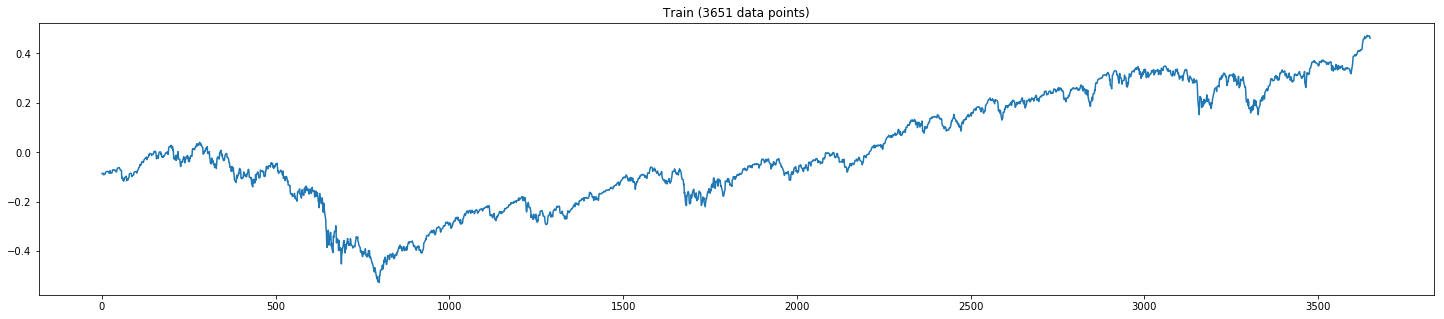

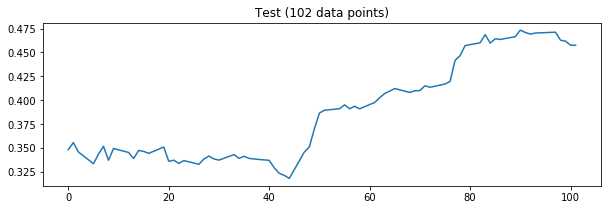

In [372]:
plt.figure(figsize=(25,5))
plt.plot(xTrain[:,0])
plt.title('Train (' +str(len(xTrain))+' data points)')
plt.show()
plt.figure(figsize=(10,3))
plt.plot(xTest[:,0])
plt.title('Test (' +str(len(xTest))+' data points)')
plt.show()

Placeholders

In [384]:
tf.reset_default_graph()

In [385]:
batchX_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_features],name='data_ph')
batchY_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_classes],name='target_ph')

Weights and biases

Because is a 3 layer net:

Input

Hidden Recurrent layer

Output

We need 2 pairs of W and b

In [386]:
W2 = tf.Variable(initial_value=np.random.rand(state_size,num_classes),dtype=tf.float32)
b2 = tf.Variable(initial_value=np.random.rand(1,num_classes),dtype=tf.float32)

Unpack

In [387]:
labels_series = tf.unstack(batchY_placeholder, axis=1)

Forward pass - Unroll the cell

In [388]:
cell = tf.contrib.rnn.BasicLSTMCell(num_units=state_size)

states_series, current_state = tf.nn.dynamic_rnn(cell=cell,inputs=batchX_placeholder,dtype=tf.float32)

In [389]:
states_series = tf.transpose(states_series,[1,0,2])

Backward pass - Output

In [390]:
last_state = tf.gather(params=states_series,indices=states_series.get_shape()[0]-1)
last_label = tf.gather(params=labels_series,indices=len(labels_series)-1)

Backward pass - Output

In [391]:
weight = tf.Variable(tf.truncated_normal([state_size,num_classes]))
bias = tf.Variable(tf.constant(0.1,shape=[num_classes]))

Backward pass - Output

In [392]:
prediction = tf.matmul(last_state,weight) + bias
prediction

<tf.Tensor 'add:0' shape=(?, 1) dtype=float32>

In [393]:
loss = tf.reduce_mean(tf.squared_difference(last_label,prediction))

train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

C:\Users\user\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [394]:
loss_list = []
test_pred_list = []

with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    
    for epoch_idx in range(num_epochs):
                
        print('Epoch %d' %epoch_idx)
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length * batch_size
        
            
            batchX = xTrain[start_idx:end_idx,:].reshape(batch_size,truncated_backprop_length,num_features)
            batchY = yTrain[start_idx:end_idx].reshape(batch_size,truncated_backprop_length,1)
                
            #print('IDXs',start_idx,end_idx)
            #print('X',batchX.shape,batchX)
            #print('Y',batchX.shape,batchY)
            
            feed = {batchX_placeholder : batchX, batchY_placeholder : batchY}
            
            #TRAIN!
            _loss,_train_step,_pred,_last_label,_prediction = sess.run(
                fetches=[loss,train_step,prediction,last_label,prediction],
                feed_dict = feed
            )
            
            loss_list.append(_loss)
            
           
            
            if(batch_idx % 50 == 0):
                print('Step %d - Loss: %.6f' %(batch_idx,_loss))
                
    #TEST
    
    
    for test_idx in range(len(xTest) - truncated_backprop_length):
        
        testBatchX = xTest[test_idx:test_idx+truncated_backprop_length,:].reshape((1,truncated_backprop_length,num_features))        
        testBatchY = yTest[test_idx:test_idx+truncated_backprop_length].reshape((1,truncated_backprop_length,1))

        
        #_current_state = np.zeros((batch_size,state_size))
        feed = {batchX_placeholder : testBatchX,
            batchY_placeholder : testBatchY}

        #Test_pred contains 'window_size' predictions, we want the last one
        _last_state,_last_label,test_pred = sess.run([last_state,last_label,prediction],feed_dict=feed)
        test_pred_list.append(test_pred[-1][0]) #The last one

Epoch 0
Step 0 - Loss: 0.015808
Step 50 - Loss: 0.000079
Step 100 - Loss: 0.000003
Step 150 - Loss: 0.000207
Step 200 - Loss: 0.000008
Step 250 - Loss: 0.000006
Step 300 - Loss: 0.000049
Step 350 - Loss: 0.000014
Step 400 - Loss: 0.000001
Step 450 - Loss: 0.000044
Step 500 - Loss: 0.000059
Step 550 - Loss: 0.000110
Step 600 - Loss: 0.000003
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000040
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000057
Step 850 - Loss: 0.000002
Step 900 - Loss: 0.000105
Step 950 - Loss: 0.000209
Step 1000 - Loss: 0.000043
Step 1050 - Loss: 0.001238
Step 1100 - Loss: 0.000308
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000362
Epoch 1
Step 0 - Loss: 0.020602
Step 50 - Loss: 0.000011
Step 100 - Loss: 0.000051
Step 150 - Loss: 0.000004
Step 200 - Loss: 0.000120
Step 250 - Loss: 0.000001
Step 300 - Loss: 0.000249
Step 350 - Loss: 0.000107
Step 400 - Loss: 0.000004
Step 450 - Loss: 0.000078
Step 500 - Loss: 0.000017
Step 550 - Loss: 0.000032
Step 600 - Loss: 0.0000

Step 600 - Loss: 0.000021
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000033
Step 750 - Loss: 0.000003
Step 800 - Loss: 0.000004
Step 850 - Loss: 0.000003
Step 900 - Loss: 0.000036
Step 950 - Loss: 0.000190
Step 1000 - Loss: 0.000005
Step 1050 - Loss: 0.000842
Step 1100 - Loss: 0.000001
Step 1150 - Loss: 0.000007
Step 1200 - Loss: 0.000071
Epoch 13
Step 0 - Loss: 0.006204
Step 50 - Loss: 0.000000
Step 100 - Loss: 0.000087
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000023
Step 250 - Loss: 0.000166
Step 300 - Loss: 0.000155
Step 350 - Loss: 0.000009
Step 400 - Loss: 0.000000
Step 450 - Loss: 0.000038
Step 500 - Loss: 0.000033
Step 550 - Loss: 0.000019
Step 600 - Loss: 0.000026
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000034
Step 750 - Loss: 0.000003
Step 800 - Loss: 0.000004
Step 850 - Loss: 0.000003
Step 900 - Loss: 0.000035
Step 950 - Loss: 0.000187
Step 1000 - Loss: 0.000006
Step 1050 - Loss: 0.000821
Step 1100 - Loss: 0.000000
Step 1150 - Loss: 0.000008
Step 1200 - Loss: 0.000

Step 1100 - Loss: 0.000005
Step 1150 - Loss: 0.000004
Step 1200 - Loss: 0.000006
Epoch 25
Step 0 - Loss: 0.003864
Step 50 - Loss: 0.000000
Step 100 - Loss: 0.000147
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000018
Step 250 - Loss: 0.000222
Step 300 - Loss: 0.000103
Step 350 - Loss: 0.000000
Step 400 - Loss: 0.000004
Step 450 - Loss: 0.000034
Step 500 - Loss: 0.000030
Step 550 - Loss: 0.000024
Step 600 - Loss: 0.000144
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000032
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000004
Step 900 - Loss: 0.000028
Step 950 - Loss: 0.000137
Step 1000 - Loss: 0.000012
Step 1050 - Loss: 0.000667
Step 1100 - Loss: 0.000005
Step 1150 - Loss: 0.000003
Step 1200 - Loss: 0.000006
Epoch 26
Step 0 - Loss: 0.003722
Step 50 - Loss: 0.000000
Step 100 - Loss: 0.000151
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000018
Step 250 - Loss: 0.000223
Step 300 - Loss: 0.000099
Step 350 - Loss: 0.000000
Step 400 - Loss: 0.000004
Step 450 - Loss: 0

Step 400 - Loss: 0.000009
Step 450 - Loss: 0.000035
Step 500 - Loss: 0.000026
Step 550 - Loss: 0.000012
Step 600 - Loss: 0.000228
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000030
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000000
Step 850 - Loss: 0.000005
Step 900 - Loss: 0.000019
Step 950 - Loss: 0.000113
Step 1000 - Loss: 0.000006
Step 1050 - Loss: 0.000664
Step 1100 - Loss: 0.000003
Step 1150 - Loss: 0.000001
Step 1200 - Loss: 0.000007
Epoch 38
Step 0 - Loss: 0.002265
Step 50 - Loss: 0.000002
Step 100 - Loss: 0.000175
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000010
Step 250 - Loss: 0.000336
Step 300 - Loss: 0.000052
Step 350 - Loss: 0.000001
Step 400 - Loss: 0.000009
Step 450 - Loss: 0.000035
Step 500 - Loss: 0.000026
Step 550 - Loss: 0.000011
Step 600 - Loss: 0.000232
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000030
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000000
Step 850 - Loss: 0.000005
Step 900 - Loss: 0.000019
Step 950 - Loss: 0.000113
Step 1000 - Loss: 0.000006


Step 1000 - Loss: 0.000002
Step 1050 - Loss: 0.000685
Step 1100 - Loss: 0.000003
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000028
Epoch 50
Step 0 - Loss: 0.001069
Step 50 - Loss: 0.000009
Step 100 - Loss: 0.000188
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000004
Step 250 - Loss: 0.000599
Step 300 - Loss: 0.000030
Step 350 - Loss: 0.000007
Step 400 - Loss: 0.000021
Step 450 - Loss: 0.000037
Step 500 - Loss: 0.000021
Step 550 - Loss: 0.000001
Step 600 - Loss: 0.000268
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000036
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000009
Step 900 - Loss: 0.000016
Step 950 - Loss: 0.000117
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000687
Step 1100 - Loss: 0.000003
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000031
Epoch 51
Step 0 - Loss: 0.000992
Step 50 - Loss: 0.000010
Step 100 - Loss: 0.000189
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000004
Step 250 - Loss: 0.000617
Step 300 - Loss: 0.000031
Step 350 - Loss:

Step 250 - Loss: 0.000626
Step 300 - Loss: 0.000101
Step 350 - Loss: 0.000005
Step 400 - Loss: 0.000034
Step 450 - Loss: 0.000044
Step 500 - Loss: 0.000014
Step 550 - Loss: 0.000001
Step 600 - Loss: 0.000286
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000040
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000006
Step 850 - Loss: 0.000010
Step 900 - Loss: 0.000014
Step 950 - Loss: 0.000129
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000690
Step 1100 - Loss: 0.000004
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000065
Epoch 63
Step 0 - Loss: 0.000417
Step 50 - Loss: 0.000017
Step 100 - Loss: 0.000193
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000001
Step 250 - Loss: 0.000615
Step 300 - Loss: 0.000110
Step 350 - Loss: 0.000004
Step 400 - Loss: 0.000034
Step 450 - Loss: 0.000045
Step 500 - Loss: 0.000014
Step 550 - Loss: 0.000001
Step 600 - Loss: 0.000288
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000040
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000006
Step 850 - Loss: 0.000010
S

Step 800 - Loss: 0.000008
Step 850 - Loss: 0.000010
Step 900 - Loss: 0.000015
Step 950 - Loss: 0.000140
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000684
Step 1100 - Loss: 0.000005
Step 1150 - Loss: 0.000002
Step 1200 - Loss: 0.000073
Epoch 75
Step 0 - Loss: 0.000264
Step 50 - Loss: 0.000018
Step 100 - Loss: 0.000188
Step 150 - Loss: 0.000004
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000466
Step 300 - Loss: 0.000196
Step 350 - Loss: 0.000000
Step 400 - Loss: 0.000035
Step 450 - Loss: 0.000048
Step 500 - Loss: 0.000012
Step 550 - Loss: 0.000002
Step 600 - Loss: 0.000300
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000041
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000008
Step 850 - Loss: 0.000009
Step 900 - Loss: 0.000015
Step 950 - Loss: 0.000140
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000684
Step 1100 - Loss: 0.000006
Step 1150 - Loss: 0.000002
Step 1200 - Loss: 0.000073
Epoch 76
Step 0 - Loss: 0.000259
Step 50 - Loss: 0.000018
Step 100 - Loss: 0.000187
Step 150 - Loss:

Step 100 - Loss: 0.000183
Step 150 - Loss: 0.000004
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000357
Step 300 - Loss: 0.000230
Step 350 - Loss: 0.000000
Step 400 - Loss: 0.000032
Step 450 - Loss: 0.000049
Step 500 - Loss: 0.000011
Step 550 - Loss: 0.000001
Step 600 - Loss: 0.000312
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000042
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000007
Step 850 - Loss: 0.000009
Step 900 - Loss: 0.000015
Step 950 - Loss: 0.000146
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000680
Step 1100 - Loss: 0.000008
Step 1150 - Loss: 0.000003
Step 1200 - Loss: 0.000063
Epoch 88
Step 0 - Loss: 0.000229
Step 50 - Loss: 0.000017
Step 100 - Loss: 0.000183
Step 150 - Loss: 0.000004
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000350
Step 300 - Loss: 0.000231
Step 350 - Loss: 0.000000
Step 400 - Loss: 0.000032
Step 450 - Loss: 0.000049
Step 500 - Loss: 0.000011
Step 550 - Loss: 0.000001
Step 600 - Loss: 0.000313
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000042
S

Step 700 - Loss: 0.000043
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000006
Step 850 - Loss: 0.000008
Step 900 - Loss: 0.000016
Step 950 - Loss: 0.000152
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000681
Step 1100 - Loss: 0.000011
Step 1150 - Loss: 0.000005
Step 1200 - Loss: 0.000052
Epoch 100
Step 0 - Loss: 0.000226
Step 50 - Loss: 0.000016
Step 100 - Loss: 0.000179
Step 150 - Loss: 0.000004
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000281
Step 300 - Loss: 0.000237
Step 350 - Loss: 0.000002
Step 400 - Loss: 0.000029
Step 450 - Loss: 0.000050
Step 500 - Loss: 0.000011
Step 550 - Loss: 0.000001
Step 600 - Loss: 0.000324
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000043
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000006
Step 850 - Loss: 0.000008
Step 900 - Loss: 0.000016
Step 950 - Loss: 0.000152
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000681
Step 1100 - Loss: 0.000011
Step 1150 - Loss: 0.000005
Step 1200 - Loss: 0.000051
Epoch 101
Step 0 - Loss: 0.000226
Step 50 - Los

Step 1200 - Loss: 0.000043
Epoch 112
Step 0 - Loss: 0.000225
Step 50 - Loss: 0.000015
Step 100 - Loss: 0.000176
Step 150 - Loss: 0.000004
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000230
Step 300 - Loss: 0.000240
Step 350 - Loss: 0.000004
Step 400 - Loss: 0.000026
Step 450 - Loss: 0.000051
Step 500 - Loss: 0.000011
Step 550 - Loss: 0.000001
Step 600 - Loss: 0.000336
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000043
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000006
Step 850 - Loss: 0.000008
Step 900 - Loss: 0.000016
Step 950 - Loss: 0.000154
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000680
Step 1100 - Loss: 0.000016
Step 1150 - Loss: 0.000006
Step 1200 - Loss: 0.000042
Epoch 113
Step 0 - Loss: 0.000225
Step 50 - Loss: 0.000014
Step 100 - Loss: 0.000176
Step 150 - Loss: 0.000004
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000227
Step 300 - Loss: 0.000240
Step 350 - Loss: 0.000004
Step 400 - Loss: 0.000026
Step 450 - Loss: 0.000051
Step 500 - Loss: 0.000011
Step 550 - Loss: 0

Step 450 - Loss: 0.000052
Step 500 - Loss: 0.000011
Step 550 - Loss: 0.000001
Step 600 - Loss: 0.000349
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000044
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000007
Step 900 - Loss: 0.000016
Step 950 - Loss: 0.000155
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000677
Step 1100 - Loss: 0.000020
Step 1150 - Loss: 0.000007
Step 1200 - Loss: 0.000033
Epoch 125
Step 0 - Loss: 0.000219
Step 50 - Loss: 0.000013
Step 100 - Loss: 0.000175
Step 150 - Loss: 0.000004
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000188
Step 300 - Loss: 0.000243
Step 350 - Loss: 0.000006
Step 400 - Loss: 0.000025
Step 450 - Loss: 0.000052
Step 500 - Loss: 0.000011
Step 550 - Loss: 0.000001
Step 600 - Loss: 0.000350
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000044
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000007
Step 900 - Loss: 0.000016
Step 950 - Loss: 0.000155
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.00067

Step 950 - Loss: 0.000156
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000674
Step 1100 - Loss: 0.000025
Step 1150 - Loss: 0.000008
Step 1200 - Loss: 0.000025
Epoch 137
Step 0 - Loss: 0.000209
Step 50 - Loss: 0.000012
Step 100 - Loss: 0.000174
Step 150 - Loss: 0.000004
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000156
Step 300 - Loss: 0.000245
Step 350 - Loss: 0.000007
Step 400 - Loss: 0.000025
Step 450 - Loss: 0.000053
Step 500 - Loss: 0.000011
Step 550 - Loss: 0.000001
Step 600 - Loss: 0.000363
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000045
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000007
Step 900 - Loss: 0.000015
Step 950 - Loss: 0.000156
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000674
Step 1100 - Loss: 0.000026
Step 1150 - Loss: 0.000008
Step 1200 - Loss: 0.000024
Epoch 138
Step 0 - Loss: 0.000208
Step 50 - Loss: 0.000012
Step 100 - Loss: 0.000174
Step 150 - Loss: 0.000004
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000154
Step 300 - Los

Step 200 - Loss: 0.000001
Step 250 - Loss: 0.000130
Step 300 - Loss: 0.000245
Step 350 - Loss: 0.000008
Step 400 - Loss: 0.000025
Step 450 - Loss: 0.000053
Step 500 - Loss: 0.000012
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000376
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000046
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000006
Step 900 - Loss: 0.000015
Step 950 - Loss: 0.000156
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000672
Step 1100 - Loss: 0.000031
Step 1150 - Loss: 0.000008
Step 1200 - Loss: 0.000018
Epoch 150
Step 0 - Loss: 0.000199
Step 50 - Loss: 0.000011
Step 100 - Loss: 0.000175
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000001
Step 250 - Loss: 0.000128
Step 300 - Loss: 0.000245
Step 350 - Loss: 0.000008
Step 400 - Loss: 0.000025
Step 450 - Loss: 0.000053
Step 500 - Loss: 0.000012
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000377
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000046
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000005


Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000007
Step 900 - Loss: 0.000014
Step 950 - Loss: 0.000157
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000672
Step 1100 - Loss: 0.000036
Step 1150 - Loss: 0.000009
Step 1200 - Loss: 0.000014
Epoch 162
Step 0 - Loss: 0.000192
Step 50 - Loss: 0.000010
Step 100 - Loss: 0.000177
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000001
Step 250 - Loss: 0.000107
Step 300 - Loss: 0.000245
Step 350 - Loss: 0.000010
Step 400 - Loss: 0.000025
Step 450 - Loss: 0.000054
Step 500 - Loss: 0.000013
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000389
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000048
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000007
Step 900 - Loss: 0.000014
Step 950 - Loss: 0.000157
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000672
Step 1100 - Loss: 0.000036
Step 1150 - Loss: 0.000009
Step 1200 - Loss: 0.000014
Epoch 163
Step 0 - Loss: 0.000191
Step 50 - Loss: 0.000010
Step 100 - Los

Step 50 - Loss: 0.000009
Step 100 - Loss: 0.000179
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000001
Step 250 - Loss: 0.000089
Step 300 - Loss: 0.000244
Step 350 - Loss: 0.000012
Step 400 - Loss: 0.000025
Step 450 - Loss: 0.000054
Step 500 - Loss: 0.000013
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000400
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000050
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000007
Step 900 - Loss: 0.000014
Step 950 - Loss: 0.000159
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000674
Step 1100 - Loss: 0.000041
Step 1150 - Loss: 0.000009
Step 1200 - Loss: 0.000010
Epoch 175
Step 0 - Loss: 0.000187
Step 50 - Loss: 0.000009
Step 100 - Loss: 0.000179
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000001
Step 250 - Loss: 0.000087
Step 300 - Loss: 0.000244
Step 350 - Loss: 0.000012
Step 400 - Loss: 0.000025
Step 450 - Loss: 0.000054
Step 500 - Loss: 0.000013
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000401
Step 650 - Loss: 0.000000
S

Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000409
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000052
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000008
Step 900 - Loss: 0.000014
Step 950 - Loss: 0.000161
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000677
Step 1100 - Loss: 0.000046
Step 1150 - Loss: 0.000009
Step 1200 - Loss: 0.000008
Epoch 187
Step 0 - Loss: 0.000183
Step 50 - Loss: 0.000008
Step 100 - Loss: 0.000180
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000001
Step 250 - Loss: 0.000073
Step 300 - Loss: 0.000244
Step 350 - Loss: 0.000014
Step 400 - Loss: 0.000024
Step 450 - Loss: 0.000055
Step 500 - Loss: 0.000014
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000409
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000052
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000008
Step 900 - Loss: 0.000014
Step 950 - Loss: 0.000161
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000678
Step 1100 - Loss: 0.000046
Step 1150 - Loss: 0.000

Step 1050 - Loss: 0.000682
Step 1100 - Loss: 0.000050
Step 1150 - Loss: 0.000009
Step 1200 - Loss: 0.000007
Epoch 199
Step 0 - Loss: 0.000180
Step 50 - Loss: 0.000007
Step 100 - Loss: 0.000181
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000002
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000244
Step 350 - Loss: 0.000016
Step 400 - Loss: 0.000024
Step 450 - Loss: 0.000056
Step 500 - Loss: 0.000014
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000415
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000054
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000008
Step 900 - Loss: 0.000014
Step 950 - Loss: 0.000164
Step 1000 - Loss: 0.000002
Step 1050 - Loss: 0.000682
Step 1100 - Loss: 0.000050
Step 1150 - Loss: 0.000009
Step 1200 - Loss: 0.000007
Epoch 200
Step 0 - Loss: 0.000180
Step 50 - Loss: 0.000007
Step 100 - Loss: 0.000181
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000002
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000245
Step 350 - Loss: 0.000016
Step 400 - Loss

Step 350 - Loss: 0.000018
Step 400 - Loss: 0.000024
Step 450 - Loss: 0.000056
Step 500 - Loss: 0.000014
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000419
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000055
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000009
Step 900 - Loss: 0.000014
Step 950 - Loss: 0.000167
Step 1000 - Loss: 0.000002
Step 1050 - Loss: 0.000687
Step 1100 - Loss: 0.000055
Step 1150 - Loss: 0.000010
Step 1200 - Loss: 0.000007
Epoch 212
Step 0 - Loss: 0.000177
Step 50 - Loss: 0.000007
Step 100 - Loss: 0.000182
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000002
Step 250 - Loss: 0.000051
Step 300 - Loss: 0.000245
Step 350 - Loss: 0.000018
Step 400 - Loss: 0.000024
Step 450 - Loss: 0.000056
Step 500 - Loss: 0.000014
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000419
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000055
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000009
Step 900 - Loss: 0.000014
Step 950 - Loss: 0.000167


Step 850 - Loss: 0.000010
Step 900 - Loss: 0.000014
Step 950 - Loss: 0.000169
Step 1000 - Loss: 0.000002
Step 1050 - Loss: 0.000693
Step 1100 - Loss: 0.000059
Step 1150 - Loss: 0.000010
Step 1200 - Loss: 0.000007
Epoch 224
Step 0 - Loss: 0.000174
Step 50 - Loss: 0.000006
Step 100 - Loss: 0.000183
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000002
Step 250 - Loss: 0.000044
Step 300 - Loss: 0.000245
Step 350 - Loss: 0.000020
Step 400 - Loss: 0.000024
Step 450 - Loss: 0.000057
Step 500 - Loss: 0.000015
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000421
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000057
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000010
Step 900 - Loss: 0.000014
Step 950 - Loss: 0.000170
Step 1000 - Loss: 0.000002
Step 1050 - Loss: 0.000693
Step 1100 - Loss: 0.000059
Step 1150 - Loss: 0.000010
Step 1200 - Loss: 0.000007
Epoch 225
Step 0 - Loss: 0.000174
Step 50 - Loss: 0.000006
Step 100 - Loss: 0.000183
Step 150 - Loss: 0.000001
Step 200 - Los

Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000002
Step 250 - Loss: 0.000038
Step 300 - Loss: 0.000244
Step 350 - Loss: 0.000022
Step 400 - Loss: 0.000024
Step 450 - Loss: 0.000057
Step 500 - Loss: 0.000014
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000422
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000058
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000004
Step 850 - Loss: 0.000011
Step 900 - Loss: 0.000014
Step 950 - Loss: 0.000172
Step 1000 - Loss: 0.000002
Step 1050 - Loss: 0.000699
Step 1100 - Loss: 0.000062
Step 1150 - Loss: 0.000009
Step 1200 - Loss: 0.000008
Epoch 237
Step 0 - Loss: 0.000171
Step 50 - Loss: 0.000006
Step 100 - Loss: 0.000184
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000002
Step 250 - Loss: 0.000038
Step 300 - Loss: 0.000244
Step 350 - Loss: 0.000022
Step 400 - Loss: 0.000024
Step 450 - Loss: 0.000057
Step 500 - Loss: 0.000014
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000423
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000058
Step 750 - Loss: 0.000001


Step 700 - Loss: 0.000059
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000004
Step 850 - Loss: 0.000012
Step 900 - Loss: 0.000014
Step 950 - Loss: 0.000174
Step 1000 - Loss: 0.000002
Step 1050 - Loss: 0.000705
Step 1100 - Loss: 0.000065
Step 1150 - Loss: 0.000009
Step 1200 - Loss: 0.000009
Epoch 249
Step 0 - Loss: 0.000167
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000186
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000002
Step 250 - Loss: 0.000034
Step 300 - Loss: 0.000241
Step 350 - Loss: 0.000024
Step 400 - Loss: 0.000025
Step 450 - Loss: 0.000057
Step 500 - Loss: 0.000014
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000423
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000059
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000004
Step 850 - Loss: 0.000012
Step 900 - Loss: 0.000014
Step 950 - Loss: 0.000174
Step 1000 - Loss: 0.000002
Step 1050 - Loss: 0.000706
Step 1100 - Loss: 0.000066
Step 1150 - Loss: 0.000009
Step 1200 - Loss: 0.000009
Epoch 250
Step 0 - Loss: 0.000167
Step 50 - Los

Epoch 261
Step 0 - Loss: 0.000164
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000187
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000002
Step 250 - Loss: 0.000030
Step 300 - Loss: 0.000237
Step 350 - Loss: 0.000026
Step 400 - Loss: 0.000025
Step 450 - Loss: 0.000057
Step 500 - Loss: 0.000014
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000423
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000060
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000004
Step 850 - Loss: 0.000013
Step 900 - Loss: 0.000014
Step 950 - Loss: 0.000176
Step 1000 - Loss: 0.000002
Step 1050 - Loss: 0.000712
Step 1100 - Loss: 0.000068
Step 1150 - Loss: 0.000009
Step 1200 - Loss: 0.000011
Epoch 262
Step 0 - Loss: 0.000164
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000187
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000002
Step 250 - Loss: 0.000030
Step 300 - Loss: 0.000236
Step 350 - Loss: 0.000026
Step 400 - Loss: 0.000025
Step 450 - Loss: 0.000057
Step 500 - Loss: 0.000014
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.

Step 500 - Loss: 0.000013
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000422
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000062
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000004
Step 850 - Loss: 0.000013
Step 900 - Loss: 0.000014
Step 950 - Loss: 0.000177
Step 1000 - Loss: 0.000002
Step 1050 - Loss: 0.000718
Step 1100 - Loss: 0.000070
Step 1150 - Loss: 0.000008
Step 1200 - Loss: 0.000013
Epoch 274
Step 0 - Loss: 0.000161
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000189
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000002
Step 250 - Loss: 0.000028
Step 300 - Loss: 0.000229
Step 350 - Loss: 0.000028
Step 400 - Loss: 0.000026
Step 450 - Loss: 0.000057
Step 500 - Loss: 0.000013
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000422
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000062
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000004
Step 850 - Loss: 0.000013
Step 900 - Loss: 0.000014
Step 950 - Loss: 0.000177
Step 1000 - Loss: 0.000002
Step 1050 - Loss: 0.000718
Step 1100 - Loss: 0.0000

Step 1000 - Loss: 0.000002
Step 1050 - Loss: 0.000723
Step 1100 - Loss: 0.000072
Step 1150 - Loss: 0.000007
Step 1200 - Loss: 0.000015
Epoch 286
Step 0 - Loss: 0.000159
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000191
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000002
Step 250 - Loss: 0.000027
Step 300 - Loss: 0.000219
Step 350 - Loss: 0.000030
Step 400 - Loss: 0.000026
Step 450 - Loss: 0.000057
Step 500 - Loss: 0.000013
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000421
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000064
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000004
Step 850 - Loss: 0.000014
Step 900 - Loss: 0.000014
Step 950 - Loss: 0.000178
Step 1000 - Loss: 0.000002
Step 1050 - Loss: 0.000724
Step 1100 - Loss: 0.000072
Step 1150 - Loss: 0.000007
Step 1200 - Loss: 0.000015
Epoch 287
Step 0 - Loss: 0.000159
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000191
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000002
Step 250 - Loss: 0.000027
Step 300 - Loss: 0.000218
Step 350 - Los

Step 300 - Loss: 0.000207
Step 350 - Loss: 0.000031
Step 400 - Loss: 0.000027
Step 450 - Loss: 0.000056
Step 500 - Loss: 0.000013
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000420
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000066
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000003
Step 850 - Loss: 0.000015
Step 900 - Loss: 0.000014
Step 950 - Loss: 0.000180
Step 1000 - Loss: 0.000002
Step 1050 - Loss: 0.000728
Step 1100 - Loss: 0.000073
Step 1150 - Loss: 0.000005
Step 1200 - Loss: 0.000018
Epoch 299
Step 0 - Loss: 0.000157
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000192
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000002
Step 250 - Loss: 0.000026
Step 300 - Loss: 0.000206
Step 350 - Loss: 0.000032
Step 400 - Loss: 0.000027
Step 450 - Loss: 0.000056
Step 500 - Loss: 0.000012
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000420
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000066
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000003
Step 850 - Loss: 0.000015
Step 900 - Loss: 0.000014


Step 800 - Loss: 0.000003
Step 850 - Loss: 0.000015
Step 900 - Loss: 0.000014
Step 950 - Loss: 0.000181
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000732
Step 1100 - Loss: 0.000074
Step 1150 - Loss: 0.000004
Step 1200 - Loss: 0.000021
Epoch 311
Step 0 - Loss: 0.000156
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000193
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000002
Step 250 - Loss: 0.000027
Step 300 - Loss: 0.000192
Step 350 - Loss: 0.000033
Step 400 - Loss: 0.000027
Step 450 - Loss: 0.000055
Step 500 - Loss: 0.000012
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000420
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000069
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000003
Step 850 - Loss: 0.000015
Step 900 - Loss: 0.000014
Step 950 - Loss: 0.000181
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000732
Step 1100 - Loss: 0.000074
Step 1150 - Loss: 0.000004
Step 1200 - Loss: 0.000021
Epoch 312
Step 0 - Loss: 0.000156
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000193
Step 150 - Los

Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000195
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000001
Step 250 - Loss: 0.000029
Step 300 - Loss: 0.000177
Step 350 - Loss: 0.000034
Step 400 - Loss: 0.000028
Step 450 - Loss: 0.000054
Step 500 - Loss: 0.000012
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000419
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000072
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000003
Step 850 - Loss: 0.000016
Step 900 - Loss: 0.000014
Step 950 - Loss: 0.000183
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000734
Step 1100 - Loss: 0.000074
Step 1150 - Loss: 0.000003
Step 1200 - Loss: 0.000023
Epoch 324
Step 0 - Loss: 0.000156
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000195
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000001
Step 250 - Loss: 0.000029
Step 300 - Loss: 0.000176
Step 350 - Loss: 0.000034
Step 400 - Loss: 0.000028
Step 450 - Loss: 0.000054
Step 500 - Loss: 0.000012
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000419
Step 650 - Loss: 0.000000
S

Step 600 - Loss: 0.000418
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000076
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000003
Step 850 - Loss: 0.000016
Step 900 - Loss: 0.000014
Step 950 - Loss: 0.000184
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000734
Step 1100 - Loss: 0.000075
Step 1150 - Loss: 0.000002
Step 1200 - Loss: 0.000024
Epoch 336
Step 0 - Loss: 0.000156
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000196
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000001
Step 250 - Loss: 0.000032
Step 300 - Loss: 0.000161
Step 350 - Loss: 0.000035
Step 400 - Loss: 0.000028
Step 450 - Loss: 0.000053
Step 500 - Loss: 0.000011
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000418
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000076
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000003
Step 850 - Loss: 0.000016
Step 900 - Loss: 0.000014
Step 950 - Loss: 0.000184
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000734
Step 1100 - Loss: 0.000075
Step 1150 - Loss: 0.000002
Step 1200 - Loss: 0.00

Step 1100 - Loss: 0.000075
Step 1150 - Loss: 0.000001
Step 1200 - Loss: 0.000024
Epoch 348
Step 0 - Loss: 0.000156
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000197
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000001
Step 250 - Loss: 0.000035
Step 300 - Loss: 0.000148
Step 350 - Loss: 0.000036
Step 400 - Loss: 0.000028
Step 450 - Loss: 0.000052
Step 500 - Loss: 0.000011
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000417
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000079
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000003
Step 850 - Loss: 0.000016
Step 900 - Loss: 0.000013
Step 950 - Loss: 0.000184
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000733
Step 1100 - Loss: 0.000075
Step 1150 - Loss: 0.000001
Step 1200 - Loss: 0.000024
Epoch 349
Step 0 - Loss: 0.000156
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000197
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000001
Step 250 - Loss: 0.000036
Step 300 - Loss: 0.000147
Step 350 - Loss: 0.000036
Step 400 - Loss: 0.000028
Step 450 - Loss:

Step 400 - Loss: 0.000028
Step 450 - Loss: 0.000051
Step 500 - Loss: 0.000011
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000416
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000082
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000016
Step 900 - Loss: 0.000013
Step 950 - Loss: 0.000183
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000731
Step 1100 - Loss: 0.000075
Step 1150 - Loss: 0.000001
Step 1200 - Loss: 0.000023
Epoch 361
Step 0 - Loss: 0.000156
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000197
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000001
Step 250 - Loss: 0.000040
Step 300 - Loss: 0.000135
Step 350 - Loss: 0.000037
Step 400 - Loss: 0.000028
Step 450 - Loss: 0.000051
Step 500 - Loss: 0.000011
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000415
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000082
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000016
Step 900 - Loss: 0.000013
Step 950 - Loss: 0.000183
Step 1000 - Loss: 0.000001

Step 900 - Loss: 0.000013
Step 950 - Loss: 0.000182
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000728
Step 1100 - Loss: 0.000074
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000022
Epoch 373
Step 0 - Loss: 0.000155
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000198
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000001
Step 250 - Loss: 0.000045
Step 300 - Loss: 0.000124
Step 350 - Loss: 0.000039
Step 400 - Loss: 0.000029
Step 450 - Loss: 0.000050
Step 500 - Loss: 0.000011
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000414
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000085
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000016
Step 900 - Loss: 0.000013
Step 950 - Loss: 0.000182
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000728
Step 1100 - Loss: 0.000074
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000022
Epoch 374
Step 0 - Loss: 0.000155
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000198
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000001
Step 250 - Los

Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000001
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000115
Step 350 - Loss: 0.000042
Step 400 - Loss: 0.000028
Step 450 - Loss: 0.000049
Step 500 - Loss: 0.000012
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000411
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000087
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000016
Step 900 - Loss: 0.000012
Step 950 - Loss: 0.000182
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000725
Step 1100 - Loss: 0.000074
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000021
Epoch 386
Step 0 - Loss: 0.000154
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000198
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000001
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000115
Step 350 - Loss: 0.000042
Step 400 - Loss: 0.000028
Step 450 - Loss: 0.000049
Step 500 - Loss: 0.000012
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000411
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000087
Step 750 - Loss: 0.000001


Step 700 - Loss: 0.000088
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000016
Step 900 - Loss: 0.000012
Step 950 - Loss: 0.000181
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000723
Step 1100 - Loss: 0.000073
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000020
Epoch 398
Step 0 - Loss: 0.000152
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000199
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000001
Step 250 - Loss: 0.000055
Step 300 - Loss: 0.000107
Step 350 - Loss: 0.000045
Step 400 - Loss: 0.000028
Step 450 - Loss: 0.000048
Step 500 - Loss: 0.000012
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000409
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000088
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000016
Step 900 - Loss: 0.000012
Step 950 - Loss: 0.000181
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000723
Step 1100 - Loss: 0.000073
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000020
Epoch 399
Step 0 - Loss: 0.000152
Step 50 - Los

Step 1200 - Loss: 0.000019
Epoch 410
Step 0 - Loss: 0.000149
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000199
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000002
Step 250 - Loss: 0.000059
Step 300 - Loss: 0.000101
Step 350 - Loss: 0.000049
Step 400 - Loss: 0.000028
Step 450 - Loss: 0.000047
Step 500 - Loss: 0.000013
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000406
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000088
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000016
Step 900 - Loss: 0.000012
Step 950 - Loss: 0.000180
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000721
Step 1100 - Loss: 0.000072
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000019
Epoch 411
Step 0 - Loss: 0.000149
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000199
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000002
Step 250 - Loss: 0.000060
Step 300 - Loss: 0.000101
Step 350 - Loss: 0.000049
Step 400 - Loss: 0.000028
Step 450 - Loss: 0.000047
Step 500 - Loss: 0.000013
Step 550 - Loss: 0

Step 450 - Loss: 0.000046
Step 500 - Loss: 0.000014
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000404
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000089
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000016
Step 900 - Loss: 0.000012
Step 950 - Loss: 0.000179
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000721
Step 1100 - Loss: 0.000070
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000018
Epoch 423
Step 0 - Loss: 0.000146
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000199
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000002
Step 250 - Loss: 0.000063
Step 300 - Loss: 0.000097
Step 350 - Loss: 0.000053
Step 400 - Loss: 0.000028
Step 450 - Loss: 0.000046
Step 500 - Loss: 0.000014
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000404
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000089
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000016
Step 900 - Loss: 0.000012
Step 950 - Loss: 0.000179
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.00072

Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000721
Step 1100 - Loss: 0.000068
Step 1150 - Loss: 0.000001
Step 1200 - Loss: 0.000019
Epoch 435
Step 0 - Loss: 0.000142
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000199
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000002
Step 250 - Loss: 0.000066
Step 300 - Loss: 0.000094
Step 350 - Loss: 0.000058
Step 400 - Loss: 0.000028
Step 450 - Loss: 0.000045
Step 500 - Loss: 0.000015
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000402
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000089
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000015
Step 900 - Loss: 0.000012
Step 950 - Loss: 0.000178
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000721
Step 1100 - Loss: 0.000068
Step 1150 - Loss: 0.000001
Step 1200 - Loss: 0.000019
Epoch 436
Step 0 - Loss: 0.000141
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000199
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000002
Step 250 - Loss: 0.000067
Step 300 - Loss: 0.000094
Step 350 - Los

Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000093
Step 350 - Loss: 0.000063
Step 400 - Loss: 0.000028
Step 450 - Loss: 0.000045
Step 500 - Loss: 0.000016
Step 550 - Loss: 0.000001
Step 600 - Loss: 0.000400
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000088
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000015
Step 900 - Loss: 0.000012
Step 950 - Loss: 0.000176
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000721
Step 1100 - Loss: 0.000065
Step 1150 - Loss: 0.000002
Step 1200 - Loss: 0.000019
Epoch 448
Step 0 - Loss: 0.000137
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000199
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000003
Step 250 - Loss: 0.000069
Step 300 - Loss: 0.000093
Step 350 - Loss: 0.000063
Step 400 - Loss: 0.000028
Step 450 - Loss: 0.000045
Step 500 - Loss: 0.000016
Step 550 - Loss: 0.000001
Step 600 - Loss: 0.000400
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000088
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000015


Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000015
Step 900 - Loss: 0.000013
Step 950 - Loss: 0.000175
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000723
Step 1100 - Loss: 0.000062
Step 1150 - Loss: 0.000003
Step 1200 - Loss: 0.000021
Epoch 460
Step 0 - Loss: 0.000131
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000199
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000004
Step 250 - Loss: 0.000071
Step 300 - Loss: 0.000093
Step 350 - Loss: 0.000068
Step 400 - Loss: 0.000028
Step 450 - Loss: 0.000044
Step 500 - Loss: 0.000017
Step 550 - Loss: 0.000001
Step 600 - Loss: 0.000399
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000088
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000015
Step 900 - Loss: 0.000013
Step 950 - Loss: 0.000175
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000723
Step 1100 - Loss: 0.000062
Step 1150 - Loss: 0.000004
Step 1200 - Loss: 0.000021
Epoch 461
Step 0 - Loss: 0.000131
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000199
Step 150 - Los

Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000199
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000004
Step 250 - Loss: 0.000072
Step 300 - Loss: 0.000094
Step 350 - Loss: 0.000073
Step 400 - Loss: 0.000027
Step 450 - Loss: 0.000044
Step 500 - Loss: 0.000017
Step 550 - Loss: 0.000002
Step 600 - Loss: 0.000399
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000088
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000015
Step 900 - Loss: 0.000013
Step 950 - Loss: 0.000173
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000724
Step 1100 - Loss: 0.000058
Step 1150 - Loss: 0.000006
Step 1200 - Loss: 0.000023
Epoch 473
Step 0 - Loss: 0.000124
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000199
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000004
Step 250 - Loss: 0.000072
Step 300 - Loss: 0.000095
Step 350 - Loss: 0.000073
Step 400 - Loss: 0.000027
Step 450 - Loss: 0.000044
Step 500 - Loss: 0.000018
Step 550 - Loss: 0.000002
Step 600 - Loss: 0.000399
Step 650 - Loss: 0.000000
S

Step 600 - Loss: 0.000398
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000088
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000015
Step 900 - Loss: 0.000013
Step 950 - Loss: 0.000172
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000726
Step 1100 - Loss: 0.000053
Step 1150 - Loss: 0.000008
Step 1200 - Loss: 0.000025
Epoch 485
Step 0 - Loss: 0.000118
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000199
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000005
Step 250 - Loss: 0.000073
Step 300 - Loss: 0.000097
Step 350 - Loss: 0.000077
Step 400 - Loss: 0.000027
Step 450 - Loss: 0.000043
Step 500 - Loss: 0.000018
Step 550 - Loss: 0.000003
Step 600 - Loss: 0.000398
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000088
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000015
Step 900 - Loss: 0.000013
Step 950 - Loss: 0.000171
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000726
Step 1100 - Loss: 0.000053
Step 1150 - Loss: 0.000009
Step 1200 - Loss: 0.00

Step 1100 - Loss: 0.000048
Step 1150 - Loss: 0.000012
Step 1200 - Loss: 0.000028
Epoch 497
Step 0 - Loss: 0.000111
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000199
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000006
Step 250 - Loss: 0.000073
Step 300 - Loss: 0.000101
Step 350 - Loss: 0.000081
Step 400 - Loss: 0.000027
Step 450 - Loss: 0.000043
Step 500 - Loss: 0.000019
Step 550 - Loss: 0.000004
Step 600 - Loss: 0.000398
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000088
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000015
Step 900 - Loss: 0.000014
Step 950 - Loss: 0.000169
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000727
Step 1100 - Loss: 0.000047
Step 1150 - Loss: 0.000012
Step 1200 - Loss: 0.000028
Epoch 498
Step 0 - Loss: 0.000111
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000199
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000006
Step 250 - Loss: 0.000073
Step 300 - Loss: 0.000101
Step 350 - Loss: 0.000082
Step 400 - Loss: 0.000027
Step 450 - Loss:

Step 400 - Loss: 0.000026
Step 450 - Loss: 0.000042
Step 500 - Loss: 0.000019
Step 550 - Loss: 0.000005
Step 600 - Loss: 0.000399
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000089
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000015
Step 900 - Loss: 0.000014
Step 950 - Loss: 0.000168
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000727
Step 1100 - Loss: 0.000042
Step 1150 - Loss: 0.000016
Step 1200 - Loss: 0.000031
Epoch 510
Step 0 - Loss: 0.000104
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000199
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000007
Step 250 - Loss: 0.000073
Step 300 - Loss: 0.000106
Step 350 - Loss: 0.000085
Step 400 - Loss: 0.000026
Step 450 - Loss: 0.000042
Step 500 - Loss: 0.000019
Step 550 - Loss: 0.000005
Step 600 - Loss: 0.000399
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000089
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000015
Step 900 - Loss: 0.000014
Step 950 - Loss: 0.000167
Step 1000 - Loss: 0.000001

Step 900 - Loss: 0.000014
Step 950 - Loss: 0.000166
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000726
Step 1100 - Loss: 0.000037
Step 1150 - Loss: 0.000021
Step 1200 - Loss: 0.000034
Epoch 522
Step 0 - Loss: 0.000098
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000199
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000008
Step 250 - Loss: 0.000073
Step 300 - Loss: 0.000112
Step 350 - Loss: 0.000088
Step 400 - Loss: 0.000026
Step 450 - Loss: 0.000042
Step 500 - Loss: 0.000020
Step 550 - Loss: 0.000006
Step 600 - Loss: 0.000399
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000089
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000015
Step 900 - Loss: 0.000014
Step 950 - Loss: 0.000165
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000726
Step 1100 - Loss: 0.000037
Step 1150 - Loss: 0.000021
Step 1200 - Loss: 0.000034
Epoch 523
Step 0 - Loss: 0.000097
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000199
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000008
Step 250 - Los

Step 200 - Loss: 0.000009
Step 250 - Loss: 0.000073
Step 300 - Loss: 0.000118
Step 350 - Loss: 0.000090
Step 400 - Loss: 0.000025
Step 450 - Loss: 0.000041
Step 500 - Loss: 0.000020
Step 550 - Loss: 0.000007
Step 600 - Loss: 0.000399
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000090
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000015
Step 900 - Loss: 0.000015
Step 950 - Loss: 0.000164
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000725
Step 1100 - Loss: 0.000032
Step 1150 - Loss: 0.000026
Step 1200 - Loss: 0.000037
Epoch 535
Step 0 - Loss: 0.000092
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000198
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000009
Step 250 - Loss: 0.000073
Step 300 - Loss: 0.000118
Step 350 - Loss: 0.000091
Step 400 - Loss: 0.000025
Step 450 - Loss: 0.000041
Step 500 - Loss: 0.000020
Step 550 - Loss: 0.000007
Step 600 - Loss: 0.000398
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000090
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002


Step 700 - Loss: 0.000090
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000015
Step 900 - Loss: 0.000015
Step 950 - Loss: 0.000162
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000724
Step 1100 - Loss: 0.000027
Step 1150 - Loss: 0.000032
Step 1200 - Loss: 0.000039
Epoch 547
Step 0 - Loss: 0.000087
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000198
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000010
Step 250 - Loss: 0.000073
Step 300 - Loss: 0.000125
Step 350 - Loss: 0.000093
Step 400 - Loss: 0.000024
Step 450 - Loss: 0.000041
Step 500 - Loss: 0.000020
Step 550 - Loss: 0.000009
Step 600 - Loss: 0.000398
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000090
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000015
Step 900 - Loss: 0.000015
Step 950 - Loss: 0.000162
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000724
Step 1100 - Loss: 0.000027
Step 1150 - Loss: 0.000032
Step 1200 - Loss: 0.000039
Epoch 548
Step 0 - Loss: 0.000086
Step 50 - Los

Step 1200 - Loss: 0.000041
Epoch 559
Step 0 - Loss: 0.000082
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000197
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000011
Step 250 - Loss: 0.000074
Step 300 - Loss: 0.000132
Step 350 - Loss: 0.000095
Step 400 - Loss: 0.000023
Step 450 - Loss: 0.000040
Step 500 - Loss: 0.000020
Step 550 - Loss: 0.000010
Step 600 - Loss: 0.000398
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000091
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000016
Step 900 - Loss: 0.000015
Step 950 - Loss: 0.000161
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000722
Step 1100 - Loss: 0.000023
Step 1150 - Loss: 0.000037
Step 1200 - Loss: 0.000042
Epoch 560
Step 0 - Loss: 0.000082
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000196
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000011
Step 250 - Loss: 0.000074
Step 300 - Loss: 0.000133
Step 350 - Loss: 0.000095
Step 400 - Loss: 0.000023
Step 450 - Loss: 0.000040
Step 500 - Loss: 0.000020
Step 550 - Loss: 0

Step 450 - Loss: 0.000040
Step 500 - Loss: 0.000020
Step 550 - Loss: 0.000012
Step 600 - Loss: 0.000397
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000091
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000016
Step 900 - Loss: 0.000015
Step 950 - Loss: 0.000160
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000719
Step 1100 - Loss: 0.000019
Step 1150 - Loss: 0.000042
Step 1200 - Loss: 0.000043
Epoch 572
Step 0 - Loss: 0.000078
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000195
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000012
Step 250 - Loss: 0.000074
Step 300 - Loss: 0.000140
Step 350 - Loss: 0.000097
Step 400 - Loss: 0.000022
Step 450 - Loss: 0.000040
Step 500 - Loss: 0.000020
Step 550 - Loss: 0.000012
Step 600 - Loss: 0.000397
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000091
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000016
Step 900 - Loss: 0.000015
Step 950 - Loss: 0.000160
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.00071

Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000716
Step 1100 - Loss: 0.000016
Step 1150 - Loss: 0.000045
Step 1200 - Loss: 0.000044
Epoch 584
Step 0 - Loss: 0.000075
Step 50 - Loss: 0.000004
Step 100 - Loss: 0.000194
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000012
Step 250 - Loss: 0.000075
Step 300 - Loss: 0.000149
Step 350 - Loss: 0.000100
Step 400 - Loss: 0.000021
Step 450 - Loss: 0.000040
Step 500 - Loss: 0.000020
Step 550 - Loss: 0.000014
Step 600 - Loss: 0.000395
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000091
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000017
Step 900 - Loss: 0.000016
Step 950 - Loss: 0.000159
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000716
Step 1100 - Loss: 0.000016
Step 1150 - Loss: 0.000045
Step 1200 - Loss: 0.000044
Epoch 585
Step 0 - Loss: 0.000075
Step 50 - Loss: 0.000004
Step 100 - Loss: 0.000193
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000012
Step 250 - Loss: 0.000075
Step 300 - Loss: 0.000149
Step 350 - Los

Step 250 - Loss: 0.000075
Step 300 - Loss: 0.000157
Step 350 - Loss: 0.000103
Step 400 - Loss: 0.000020
Step 450 - Loss: 0.000039
Step 500 - Loss: 0.000020
Step 550 - Loss: 0.000015
Step 600 - Loss: 0.000394
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000091
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000018
Step 900 - Loss: 0.000016
Step 950 - Loss: 0.000159
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000713
Step 1100 - Loss: 0.000013
Step 1150 - Loss: 0.000047
Step 1200 - Loss: 0.000044
Epoch 597
Step 0 - Loss: 0.000073
Step 50 - Loss: 0.000004
Step 100 - Loss: 0.000192
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000013
Step 250 - Loss: 0.000075
Step 300 - Loss: 0.000158
Step 350 - Loss: 0.000103
Step 400 - Loss: 0.000020
Step 450 - Loss: 0.000039
Step 500 - Loss: 0.000020
Step 550 - Loss: 0.000015
Step 600 - Loss: 0.000393
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000091
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000018


Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000018
Step 900 - Loss: 0.000016
Step 950 - Loss: 0.000159
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000711
Step 1100 - Loss: 0.000011
Step 1150 - Loss: 0.000048
Step 1200 - Loss: 0.000043
Epoch 609
Step 0 - Loss: 0.000071
Step 50 - Loss: 0.000004
Step 100 - Loss: 0.000190
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000013
Step 250 - Loss: 0.000076
Step 300 - Loss: 0.000166
Step 350 - Loss: 0.000106
Step 400 - Loss: 0.000018
Step 450 - Loss: 0.000039
Step 500 - Loss: 0.000020
Step 550 - Loss: 0.000017
Step 600 - Loss: 0.000391
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000091
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000018
Step 900 - Loss: 0.000016
Step 950 - Loss: 0.000159
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000710
Step 1100 - Loss: 0.000011
Step 1150 - Loss: 0.000048
Step 1200 - Loss: 0.000042
Epoch 610
Step 0 - Loss: 0.000070
Step 50 - Loss: 0.000004
Step 100 - Los

Step 50 - Loss: 0.000004
Step 100 - Loss: 0.000187
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000014
Step 250 - Loss: 0.000077
Step 300 - Loss: 0.000175
Step 350 - Loss: 0.000110
Step 400 - Loss: 0.000017
Step 450 - Loss: 0.000039
Step 500 - Loss: 0.000020
Step 550 - Loss: 0.000018
Step 600 - Loss: 0.000389
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000091
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000018
Step 900 - Loss: 0.000016
Step 950 - Loss: 0.000159
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000708
Step 1100 - Loss: 0.000009
Step 1150 - Loss: 0.000048
Step 1200 - Loss: 0.000040
Epoch 622
Step 0 - Loss: 0.000068
Step 50 - Loss: 0.000004
Step 100 - Loss: 0.000187
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000014
Step 250 - Loss: 0.000077
Step 300 - Loss: 0.000175
Step 350 - Loss: 0.000111
Step 400 - Loss: 0.000017
Step 450 - Loss: 0.000039
Step 500 - Loss: 0.000020
Step 550 - Loss: 0.000018
Step 600 - Loss: 0.000388
Step 650 - Loss: 0.000000
S

Step 550 - Loss: 0.000018
Step 600 - Loss: 0.000385
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000091
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000019
Step 900 - Loss: 0.000016
Step 950 - Loss: 0.000159
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000705
Step 1100 - Loss: 0.000007
Step 1150 - Loss: 0.000046
Step 1200 - Loss: 0.000037
Epoch 634
Step 0 - Loss: 0.000066
Step 50 - Loss: 0.000004
Step 100 - Loss: 0.000185
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000014
Step 250 - Loss: 0.000077
Step 300 - Loss: 0.000183
Step 350 - Loss: 0.000115
Step 400 - Loss: 0.000016
Step 450 - Loss: 0.000038
Step 500 - Loss: 0.000019
Step 550 - Loss: 0.000019
Step 600 - Loss: 0.000385
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000091
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000019
Step 900 - Loss: 0.000016
Step 950 - Loss: 0.000159
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000705
Step 1100 - Loss: 0.000007
Step 1150 - Loss: 0.000

Step 1100 - Loss: 0.000005
Step 1150 - Loss: 0.000043
Step 1200 - Loss: 0.000033
Epoch 646
Step 0 - Loss: 0.000065
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000183
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000014
Step 250 - Loss: 0.000076
Step 300 - Loss: 0.000191
Step 350 - Loss: 0.000121
Step 400 - Loss: 0.000014
Step 450 - Loss: 0.000038
Step 500 - Loss: 0.000019
Step 550 - Loss: 0.000019
Step 600 - Loss: 0.000382
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000090
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000019
Step 900 - Loss: 0.000016
Step 950 - Loss: 0.000160
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000703
Step 1100 - Loss: 0.000005
Step 1150 - Loss: 0.000043
Step 1200 - Loss: 0.000033
Epoch 647
Step 0 - Loss: 0.000064
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000183
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000014
Step 250 - Loss: 0.000076
Step 300 - Loss: 0.000192
Step 350 - Loss: 0.000122
Step 400 - Loss: 0.000014
Step 450 - Loss:

Step 400 - Loss: 0.000012
Step 450 - Loss: 0.000038
Step 500 - Loss: 0.000018
Step 550 - Loss: 0.000019
Step 600 - Loss: 0.000378
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000090
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000018
Step 900 - Loss: 0.000016
Step 950 - Loss: 0.000160
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000701
Step 1100 - Loss: 0.000004
Step 1150 - Loss: 0.000040
Step 1200 - Loss: 0.000029
Epoch 659
Step 0 - Loss: 0.000063
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000181
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000014
Step 250 - Loss: 0.000075
Step 300 - Loss: 0.000200
Step 350 - Loss: 0.000129
Step 400 - Loss: 0.000012
Step 450 - Loss: 0.000038
Step 500 - Loss: 0.000018
Step 550 - Loss: 0.000019
Step 600 - Loss: 0.000378
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000090
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000018
Step 900 - Loss: 0.000016
Step 950 - Loss: 0.000160
Step 1000 - Loss: 0.000000

Step 900 - Loss: 0.000016
Step 950 - Loss: 0.000160
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000699
Step 1100 - Loss: 0.000002
Step 1150 - Loss: 0.000036
Step 1200 - Loss: 0.000025
Epoch 671
Step 0 - Loss: 0.000061
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000180
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000014
Step 250 - Loss: 0.000073
Step 300 - Loss: 0.000207
Step 350 - Loss: 0.000137
Step 400 - Loss: 0.000010
Step 450 - Loss: 0.000037
Step 500 - Loss: 0.000018
Step 550 - Loss: 0.000019
Step 600 - Loss: 0.000374
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000089
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000018
Step 900 - Loss: 0.000016
Step 950 - Loss: 0.000160
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000698
Step 1100 - Loss: 0.000002
Step 1150 - Loss: 0.000036
Step 1200 - Loss: 0.000025
Epoch 672
Step 0 - Loss: 0.000060
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000180
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000014
Step 250 - Los

Step 200 - Loss: 0.000014
Step 250 - Loss: 0.000071
Step 300 - Loss: 0.000215
Step 350 - Loss: 0.000146
Step 400 - Loss: 0.000009
Step 450 - Loss: 0.000036
Step 500 - Loss: 0.000017
Step 550 - Loss: 0.000018
Step 600 - Loss: 0.000370
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000088
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000018
Step 900 - Loss: 0.000016
Step 950 - Loss: 0.000160
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000696
Step 1100 - Loss: 0.000001
Step 1150 - Loss: 0.000032
Step 1200 - Loss: 0.000021
Epoch 684
Step 0 - Loss: 0.000058
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000179
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000014
Step 250 - Loss: 0.000071
Step 300 - Loss: 0.000215
Step 350 - Loss: 0.000147
Step 400 - Loss: 0.000009
Step 450 - Loss: 0.000036
Step 500 - Loss: 0.000017
Step 550 - Loss: 0.000018
Step 600 - Loss: 0.000370
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000088
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002


Step 700 - Loss: 0.000087
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000017
Step 900 - Loss: 0.000016
Step 950 - Loss: 0.000159
Step 1000 - Loss: 0.000002
Step 1050 - Loss: 0.000694
Step 1100 - Loss: 0.000000
Step 1150 - Loss: 0.000029
Step 1200 - Loss: 0.000017
Epoch 696
Step 0 - Loss: 0.000056
Step 50 - Loss: 0.000004
Step 100 - Loss: 0.000179
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000014
Step 250 - Loss: 0.000068
Step 300 - Loss: 0.000222
Step 350 - Loss: 0.000156
Step 400 - Loss: 0.000007
Step 450 - Loss: 0.000036
Step 500 - Loss: 0.000017
Step 550 - Loss: 0.000017
Step 600 - Loss: 0.000367
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000087
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000017
Step 900 - Loss: 0.000016
Step 950 - Loss: 0.000159
Step 1000 - Loss: 0.000002
Step 1050 - Loss: 0.000693
Step 1100 - Loss: 0.000000
Step 1150 - Loss: 0.000029
Step 1200 - Loss: 0.000017
Epoch 697
Step 0 - Loss: 0.000056
Step 50 - Los

Step 1200 - Loss: 0.000014
Epoch 708
Step 0 - Loss: 0.000054
Step 50 - Loss: 0.000004
Step 100 - Loss: 0.000179
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000014
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000228
Step 350 - Loss: 0.000166
Step 400 - Loss: 0.000006
Step 450 - Loss: 0.000035
Step 500 - Loss: 0.000017
Step 550 - Loss: 0.000016
Step 600 - Loss: 0.000363
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000086
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000017
Step 900 - Loss: 0.000017
Step 950 - Loss: 0.000159
Step 1000 - Loss: 0.000003
Step 1050 - Loss: 0.000690
Step 1100 - Loss: 0.000000
Step 1150 - Loss: 0.000026
Step 1200 - Loss: 0.000014
Epoch 709
Step 0 - Loss: 0.000054
Step 50 - Loss: 0.000004
Step 100 - Loss: 0.000179
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000014
Step 250 - Loss: 0.000064
Step 300 - Loss: 0.000228
Step 350 - Loss: 0.000167
Step 400 - Loss: 0.000006
Step 450 - Loss: 0.000035
Step 500 - Loss: 0.000017
Step 550 - Loss: 0

Step 500 - Loss: 0.000017
Step 550 - Loss: 0.000014
Step 600 - Loss: 0.000360
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000086
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000016
Step 900 - Loss: 0.000017
Step 950 - Loss: 0.000158
Step 1000 - Loss: 0.000005
Step 1050 - Loss: 0.000687
Step 1100 - Loss: 0.000000
Step 1150 - Loss: 0.000024
Step 1200 - Loss: 0.000011
Epoch 721
Step 0 - Loss: 0.000052
Step 50 - Loss: 0.000004
Step 100 - Loss: 0.000180
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000013
Step 250 - Loss: 0.000061
Step 300 - Loss: 0.000232
Step 350 - Loss: 0.000176
Step 400 - Loss: 0.000005
Step 450 - Loss: 0.000035
Step 500 - Loss: 0.000017
Step 550 - Loss: 0.000014
Step 600 - Loss: 0.000359
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000086
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000016
Step 900 - Loss: 0.000017
Step 950 - Loss: 0.000158
Step 1000 - Loss: 0.000005
Step 1050 - Loss: 0.000687
Step 1100 - Loss: 0.0000

Step 1000 - Loss: 0.000006
Step 1050 - Loss: 0.000684
Step 1100 - Loss: 0.000001
Step 1150 - Loss: 0.000022
Step 1200 - Loss: 0.000009
Epoch 733
Step 0 - Loss: 0.000050
Step 50 - Loss: 0.000004
Step 100 - Loss: 0.000181
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000013
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000233
Step 350 - Loss: 0.000184
Step 400 - Loss: 0.000004
Step 450 - Loss: 0.000034
Step 500 - Loss: 0.000017
Step 550 - Loss: 0.000012
Step 600 - Loss: 0.000356
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000085
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000016
Step 900 - Loss: 0.000018
Step 950 - Loss: 0.000158
Step 1000 - Loss: 0.000007
Step 1050 - Loss: 0.000684
Step 1100 - Loss: 0.000001
Step 1150 - Loss: 0.000022
Step 1200 - Loss: 0.000009
Epoch 734
Step 0 - Loss: 0.000049
Step 50 - Loss: 0.000004
Step 100 - Loss: 0.000181
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000013
Step 250 - Loss: 0.000057
Step 300 - Loss: 0.000233
Step 350 - Los

Step 300 - Loss: 0.000233
Step 350 - Loss: 0.000192
Step 400 - Loss: 0.000004
Step 450 - Loss: 0.000034
Step 500 - Loss: 0.000017
Step 550 - Loss: 0.000009
Step 600 - Loss: 0.000353
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000085
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000016
Step 900 - Loss: 0.000019
Step 950 - Loss: 0.000158
Step 1000 - Loss: 0.000009
Step 1050 - Loss: 0.000680
Step 1100 - Loss: 0.000001
Step 1150 - Loss: 0.000021
Step 1200 - Loss: 0.000007
Epoch 746
Step 0 - Loss: 0.000048
Step 50 - Loss: 0.000003
Step 100 - Loss: 0.000182
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000012
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000233
Step 350 - Loss: 0.000192
Step 400 - Loss: 0.000004
Step 450 - Loss: 0.000034
Step 500 - Loss: 0.000017
Step 550 - Loss: 0.000009
Step 600 - Loss: 0.000352
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000085
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000016
Step 900 - Loss: 0.000019


Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000015
Step 900 - Loss: 0.000019
Step 950 - Loss: 0.000157
Step 1000 - Loss: 0.000011
Step 1050 - Loss: 0.000676
Step 1100 - Loss: 0.000003
Step 1150 - Loss: 0.000020
Step 1200 - Loss: 0.000005
Epoch 758
Step 0 - Loss: 0.000046
Step 50 - Loss: 0.000003
Step 100 - Loss: 0.000184
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000012
Step 250 - Loss: 0.000050
Step 300 - Loss: 0.000231
Step 350 - Loss: 0.000198
Step 400 - Loss: 0.000003
Step 450 - Loss: 0.000034
Step 500 - Loss: 0.000017
Step 550 - Loss: 0.000007
Step 600 - Loss: 0.000349
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000084
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000015
Step 900 - Loss: 0.000020
Step 950 - Loss: 0.000157
Step 1000 - Loss: 0.000011
Step 1050 - Loss: 0.000676
Step 1100 - Loss: 0.000003
Step 1150 - Loss: 0.000019
Step 1200 - Loss: 0.000005
Epoch 759
Step 0 - Loss: 0.000046
Step 50 - Loss: 0.000003
Step 100 - Loss: 0.000184
Step 150 - Los

Step 50 - Loss: 0.000002
Step 100 - Loss: 0.000185
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000011
Step 250 - Loss: 0.000046
Step 300 - Loss: 0.000229
Step 350 - Loss: 0.000203
Step 400 - Loss: 0.000003
Step 450 - Loss: 0.000033
Step 500 - Loss: 0.000017
Step 550 - Loss: 0.000005
Step 600 - Loss: 0.000346
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000084
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000015
Step 900 - Loss: 0.000021
Step 950 - Loss: 0.000157
Step 1000 - Loss: 0.000014
Step 1050 - Loss: 0.000672
Step 1100 - Loss: 0.000004
Step 1150 - Loss: 0.000019
Step 1200 - Loss: 0.000003
Epoch 771
Step 0 - Loss: 0.000044
Step 50 - Loss: 0.000002
Step 100 - Loss: 0.000185
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000011
Step 250 - Loss: 0.000046
Step 300 - Loss: 0.000228
Step 350 - Loss: 0.000203
Step 400 - Loss: 0.000003
Step 450 - Loss: 0.000033
Step 500 - Loss: 0.000017
Step 550 - Loss: 0.000004
Step 600 - Loss: 0.000345
Step 650 - Loss: 0.000001
S

Step 550 - Loss: 0.000003
Step 600 - Loss: 0.000343
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000083
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000015
Step 900 - Loss: 0.000021
Step 950 - Loss: 0.000156
Step 1000 - Loss: 0.000016
Step 1050 - Loss: 0.000668
Step 1100 - Loss: 0.000006
Step 1150 - Loss: 0.000018
Step 1200 - Loss: 0.000002
Epoch 783
Step 0 - Loss: 0.000043
Step 50 - Loss: 0.000002
Step 100 - Loss: 0.000187
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000010
Step 250 - Loss: 0.000042
Step 300 - Loss: 0.000224
Step 350 - Loss: 0.000206
Step 400 - Loss: 0.000003
Step 450 - Loss: 0.000034
Step 500 - Loss: 0.000018
Step 550 - Loss: 0.000003
Step 600 - Loss: 0.000343
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000083
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000014
Step 900 - Loss: 0.000022
Step 950 - Loss: 0.000156
Step 1000 - Loss: 0.000017
Step 1050 - Loss: 0.000668
Step 1100 - Loss: 0.000006
Step 1150 - Loss: 0.000

Step 1050 - Loss: 0.000664
Step 1100 - Loss: 0.000008
Step 1150 - Loss: 0.000016
Step 1200 - Loss: 0.000002
Epoch 795
Step 0 - Loss: 0.000042
Step 50 - Loss: 0.000002
Step 100 - Loss: 0.000189
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000010
Step 250 - Loss: 0.000038
Step 300 - Loss: 0.000220
Step 350 - Loss: 0.000208
Step 400 - Loss: 0.000003
Step 450 - Loss: 0.000034
Step 500 - Loss: 0.000018
Step 550 - Loss: 0.000001
Step 600 - Loss: 0.000340
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000083
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000014
Step 900 - Loss: 0.000022
Step 950 - Loss: 0.000154
Step 1000 - Loss: 0.000019
Step 1050 - Loss: 0.000664
Step 1100 - Loss: 0.000008
Step 1150 - Loss: 0.000016
Step 1200 - Loss: 0.000001
Epoch 796
Step 0 - Loss: 0.000042
Step 50 - Loss: 0.000002
Step 100 - Loss: 0.000189
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000010
Step 250 - Loss: 0.000038
Step 300 - Loss: 0.000220
Step 350 - Loss: 0.000209
Step 400 - Loss

Step 350 - Loss: 0.000209
Step 400 - Loss: 0.000003
Step 450 - Loss: 0.000034
Step 500 - Loss: 0.000018
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000338
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000082
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000014
Step 900 - Loss: 0.000023
Step 950 - Loss: 0.000152
Step 1000 - Loss: 0.000022
Step 1050 - Loss: 0.000659
Step 1100 - Loss: 0.000011
Step 1150 - Loss: 0.000015
Step 1200 - Loss: 0.000001
Epoch 808
Step 0 - Loss: 0.000042
Step 50 - Loss: 0.000001
Step 100 - Loss: 0.000191
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000009
Step 250 - Loss: 0.000034
Step 300 - Loss: 0.000214
Step 350 - Loss: 0.000209
Step 400 - Loss: 0.000004
Step 450 - Loss: 0.000034
Step 500 - Loss: 0.000019
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000338
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000082
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000014
Step 900 - Loss: 0.000023
Step 950 - Loss: 0.000152


Step 850 - Loss: 0.000014
Step 900 - Loss: 0.000024
Step 950 - Loss: 0.000150
Step 1000 - Loss: 0.000024
Step 1050 - Loss: 0.000654
Step 1100 - Loss: 0.000013
Step 1150 - Loss: 0.000014
Step 1200 - Loss: 0.000001
Epoch 820
Step 0 - Loss: 0.000042
Step 50 - Loss: 0.000001
Step 100 - Loss: 0.000194
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000008
Step 250 - Loss: 0.000030
Step 300 - Loss: 0.000208
Step 350 - Loss: 0.000210
Step 400 - Loss: 0.000004
Step 450 - Loss: 0.000035
Step 500 - Loss: 0.000019
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000336
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000081
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000014
Step 900 - Loss: 0.000024
Step 950 - Loss: 0.000150
Step 1000 - Loss: 0.000025
Step 1050 - Loss: 0.000654
Step 1100 - Loss: 0.000013
Step 1150 - Loss: 0.000014
Step 1200 - Loss: 0.000001
Epoch 821
Step 0 - Loss: 0.000042
Step 50 - Loss: 0.000001
Step 100 - Loss: 0.000194
Step 150 - Loss: 0.000002
Step 200 - Los

Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000008
Step 250 - Loss: 0.000027
Step 300 - Loss: 0.000202
Step 350 - Loss: 0.000209
Step 400 - Loss: 0.000004
Step 450 - Loss: 0.000036
Step 500 - Loss: 0.000019
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000334
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000080
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000013
Step 900 - Loss: 0.000025
Step 950 - Loss: 0.000147
Step 1000 - Loss: 0.000027
Step 1050 - Loss: 0.000649
Step 1100 - Loss: 0.000016
Step 1150 - Loss: 0.000013
Step 1200 - Loss: 0.000000
Epoch 833
Step 0 - Loss: 0.000041
Step 50 - Loss: 0.000001
Step 100 - Loss: 0.000197
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000008
Step 250 - Loss: 0.000026
Step 300 - Loss: 0.000201
Step 350 - Loss: 0.000209
Step 400 - Loss: 0.000004
Step 450 - Loss: 0.000036
Step 500 - Loss: 0.000019
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000334
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000080
Step 750 - Loss: 0.000000


Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000079
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000013
Step 900 - Loss: 0.000025
Step 950 - Loss: 0.000145
Step 1000 - Loss: 0.000030
Step 1050 - Loss: 0.000644
Step 1100 - Loss: 0.000018
Step 1150 - Loss: 0.000012
Step 1200 - Loss: 0.000000
Epoch 845
Step 0 - Loss: 0.000042
Step 50 - Loss: 0.000001
Step 100 - Loss: 0.000199
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000007
Step 250 - Loss: 0.000023
Step 300 - Loss: 0.000194
Step 350 - Loss: 0.000208
Step 400 - Loss: 0.000004
Step 450 - Loss: 0.000037
Step 500 - Loss: 0.000019
Step 550 - Loss: 0.000001
Step 600 - Loss: 0.000333
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000079
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000013
Step 900 - Loss: 0.000025
Step 950 - Loss: 0.000145
Step 1000 - Loss: 0.000031
Step 1050 - Loss: 0.000644
Step 1100 - Loss: 0.000018
Step 1150 - Loss: 0.000012
Step 1200 - Loss: 0.000000
Epoch 846
Step 0 - Lo

Step 1150 - Loss: 0.000011
Step 1200 - Loss: 0.000000
Epoch 857
Step 0 - Loss: 0.000042
Step 50 - Loss: 0.000000
Step 100 - Loss: 0.000202
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000006
Step 250 - Loss: 0.000021
Step 300 - Loss: 0.000186
Step 350 - Loss: 0.000206
Step 400 - Loss: 0.000005
Step 450 - Loss: 0.000039
Step 500 - Loss: 0.000019
Step 550 - Loss: 0.000002
Step 600 - Loss: 0.000332
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000077
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000013
Step 900 - Loss: 0.000026
Step 950 - Loss: 0.000142
Step 1000 - Loss: 0.000034
Step 1050 - Loss: 0.000639
Step 1100 - Loss: 0.000020
Step 1150 - Loss: 0.000011
Step 1200 - Loss: 0.000000
Epoch 858
Step 0 - Loss: 0.000042
Step 50 - Loss: 0.000000
Step 100 - Loss: 0.000202
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000006
Step 250 - Loss: 0.000021
Step 300 - Loss: 0.000185
Step 350 - Loss: 0.000206
Step 400 - Loss: 0.000005
Step 450 - Loss: 0.000039
Step 500 - Loss: 

Step 400 - Loss: 0.000005
Step 450 - Loss: 0.000040
Step 500 - Loss: 0.000019
Step 550 - Loss: 0.000003
Step 600 - Loss: 0.000331
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000076
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000012
Step 900 - Loss: 0.000026
Step 950 - Loss: 0.000140
Step 1000 - Loss: 0.000037
Step 1050 - Loss: 0.000634
Step 1100 - Loss: 0.000022
Step 1150 - Loss: 0.000010
Step 1200 - Loss: 0.000000
Epoch 870
Step 0 - Loss: 0.000042
Step 50 - Loss: 0.000000
Step 100 - Loss: 0.000205
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000006
Step 250 - Loss: 0.000019
Step 300 - Loss: 0.000178
Step 350 - Loss: 0.000204
Step 400 - Loss: 0.000005
Step 450 - Loss: 0.000040
Step 500 - Loss: 0.000019
Step 550 - Loss: 0.000003
Step 600 - Loss: 0.000331
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000076
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000012
Step 900 - Loss: 0.000026
Step 950 - Loss: 0.000140
Step 1000 - Loss: 0.000037

Step 900 - Loss: 0.000026
Step 950 - Loss: 0.000138
Step 1000 - Loss: 0.000039
Step 1050 - Loss: 0.000629
Step 1100 - Loss: 0.000024
Step 1150 - Loss: 0.000009
Step 1200 - Loss: 0.000000
Epoch 882
Step 0 - Loss: 0.000043
Step 50 - Loss: 0.000000
Step 100 - Loss: 0.000207
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000005
Step 250 - Loss: 0.000018
Step 300 - Loss: 0.000171
Step 350 - Loss: 0.000202
Step 400 - Loss: 0.000005
Step 450 - Loss: 0.000042
Step 500 - Loss: 0.000019
Step 550 - Loss: 0.000004
Step 600 - Loss: 0.000331
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000074
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000012
Step 900 - Loss: 0.000026
Step 950 - Loss: 0.000138
Step 1000 - Loss: 0.000040
Step 1050 - Loss: 0.000629
Step 1100 - Loss: 0.000024
Step 1150 - Loss: 0.000009
Step 1200 - Loss: 0.000000
Epoch 883
Step 0 - Loss: 0.000043
Step 50 - Loss: 0.000000
Step 100 - Loss: 0.000207
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000005
Step 250 - Los

Step 200 - Loss: 0.000005
Step 250 - Loss: 0.000017
Step 300 - Loss: 0.000164
Step 350 - Loss: 0.000199
Step 400 - Loss: 0.000006
Step 450 - Loss: 0.000044
Step 500 - Loss: 0.000019
Step 550 - Loss: 0.000005
Step 600 - Loss: 0.000331
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000073
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000011
Step 900 - Loss: 0.000026
Step 950 - Loss: 0.000136
Step 1000 - Loss: 0.000043
Step 1050 - Loss: 0.000624
Step 1100 - Loss: 0.000026
Step 1150 - Loss: 0.000008
Step 1200 - Loss: 0.000000
Epoch 895
Step 0 - Loss: 0.000044
Step 50 - Loss: 0.000000
Step 100 - Loss: 0.000210
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000005
Step 250 - Loss: 0.000016
Step 300 - Loss: 0.000163
Step 350 - Loss: 0.000199
Step 400 - Loss: 0.000006
Step 450 - Loss: 0.000044
Step 500 - Loss: 0.000019
Step 550 - Loss: 0.000005
Step 600 - Loss: 0.000331
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000073
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000001


Step 700 - Loss: 0.000071
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000011
Step 900 - Loss: 0.000025
Step 950 - Loss: 0.000134
Step 1000 - Loss: 0.000045
Step 1050 - Loss: 0.000619
Step 1100 - Loss: 0.000028
Step 1150 - Loss: 0.000007
Step 1200 - Loss: 0.000000
Epoch 907
Step 0 - Loss: 0.000045
Step 50 - Loss: 0.000000
Step 100 - Loss: 0.000212
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000004
Step 250 - Loss: 0.000015
Step 300 - Loss: 0.000158
Step 350 - Loss: 0.000196
Step 400 - Loss: 0.000006
Step 450 - Loss: 0.000046
Step 500 - Loss: 0.000019
Step 550 - Loss: 0.000006
Step 600 - Loss: 0.000332
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000071
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000011
Step 900 - Loss: 0.000025
Step 950 - Loss: 0.000134
Step 1000 - Loss: 0.000045
Step 1050 - Loss: 0.000619
Step 1100 - Loss: 0.000028
Step 1150 - Loss: 0.000007
Step 1200 - Loss: 0.000000
Epoch 908
Step 0 - Loss: 0.000045
Step 50 - Los

Step 1200 - Loss: 0.000000
Epoch 919
Step 0 - Loss: 0.000047
Step 50 - Loss: 0.000000
Step 100 - Loss: 0.000214
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000003
Step 250 - Loss: 0.000015
Step 300 - Loss: 0.000153
Step 350 - Loss: 0.000192
Step 400 - Loss: 0.000007
Step 450 - Loss: 0.000047
Step 500 - Loss: 0.000019
Step 550 - Loss: 0.000007
Step 600 - Loss: 0.000332
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000070
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000011
Step 900 - Loss: 0.000025
Step 950 - Loss: 0.000133
Step 1000 - Loss: 0.000048
Step 1050 - Loss: 0.000613
Step 1100 - Loss: 0.000030
Step 1150 - Loss: 0.000007
Step 1200 - Loss: 0.000000
Epoch 920
Step 0 - Loss: 0.000047
Step 50 - Loss: 0.000000
Step 100 - Loss: 0.000214
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000003
Step 250 - Loss: 0.000014
Step 300 - Loss: 0.000153
Step 350 - Loss: 0.000192
Step 400 - Loss: 0.000007
Step 450 - Loss: 0.000047
Step 500 - Loss: 0.000019
Step 550 - Loss: 0

Step 450 - Loss: 0.000048
Step 500 - Loss: 0.000019
Step 550 - Loss: 0.000008
Step 600 - Loss: 0.000333
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000068
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000011
Step 900 - Loss: 0.000025
Step 950 - Loss: 0.000132
Step 1000 - Loss: 0.000050
Step 1050 - Loss: 0.000608
Step 1100 - Loss: 0.000032
Step 1150 - Loss: 0.000006
Step 1200 - Loss: 0.000000
Epoch 932
Step 0 - Loss: 0.000049
Step 50 - Loss: 0.000000
Step 100 - Loss: 0.000216
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000003
Step 250 - Loss: 0.000014
Step 300 - Loss: 0.000149
Step 350 - Loss: 0.000189
Step 400 - Loss: 0.000007
Step 450 - Loss: 0.000049
Step 500 - Loss: 0.000019
Step 550 - Loss: 0.000009
Step 600 - Loss: 0.000333
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000068
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000011
Step 900 - Loss: 0.000025
Step 950 - Loss: 0.000132
Step 1000 - Loss: 0.000050
Step 1050 - Loss: 0.00060

Step 950 - Loss: 0.000132
Step 1000 - Loss: 0.000052
Step 1050 - Loss: 0.000603
Step 1100 - Loss: 0.000033
Step 1150 - Loss: 0.000006
Step 1200 - Loss: 0.000000
Epoch 944
Step 0 - Loss: 0.000051
Step 50 - Loss: 0.000000
Step 100 - Loss: 0.000218
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000002
Step 250 - Loss: 0.000013
Step 300 - Loss: 0.000147
Step 350 - Loss: 0.000185
Step 400 - Loss: 0.000007
Step 450 - Loss: 0.000050
Step 500 - Loss: 0.000019
Step 550 - Loss: 0.000010
Step 600 - Loss: 0.000334
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000067
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000011
Step 900 - Loss: 0.000024
Step 950 - Loss: 0.000131
Step 1000 - Loss: 0.000052
Step 1050 - Loss: 0.000603
Step 1100 - Loss: 0.000033
Step 1150 - Loss: 0.000006
Step 1200 - Loss: 0.000000
Epoch 945
Step 0 - Loss: 0.000051
Step 50 - Loss: 0.000000
Step 100 - Loss: 0.000218
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000002
Step 250 - Loss: 0.000013
Step 300 - Los

Step 250 - Loss: 0.000012
Step 300 - Loss: 0.000145
Step 350 - Loss: 0.000182
Step 400 - Loss: 0.000008
Step 450 - Loss: 0.000051
Step 500 - Loss: 0.000019
Step 550 - Loss: 0.000011
Step 600 - Loss: 0.000335
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000065
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000011
Step 900 - Loss: 0.000024
Step 950 - Loss: 0.000131
Step 1000 - Loss: 0.000054
Step 1050 - Loss: 0.000598
Step 1100 - Loss: 0.000035
Step 1150 - Loss: 0.000005
Step 1200 - Loss: 0.000000
Epoch 957
Step 0 - Loss: 0.000053
Step 50 - Loss: 0.000000
Step 100 - Loss: 0.000220
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000002
Step 250 - Loss: 0.000012
Step 300 - Loss: 0.000145
Step 350 - Loss: 0.000181
Step 400 - Loss: 0.000008
Step 450 - Loss: 0.000051
Step 500 - Loss: 0.000019
Step 550 - Loss: 0.000011
Step 600 - Loss: 0.000335
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000065
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000011


Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000011
Step 900 - Loss: 0.000024
Step 950 - Loss: 0.000130
Step 1000 - Loss: 0.000055
Step 1050 - Loss: 0.000593
Step 1100 - Loss: 0.000036
Step 1150 - Loss: 0.000005
Step 1200 - Loss: 0.000000
Epoch 969
Step 0 - Loss: 0.000055
Step 50 - Loss: 0.000000
Step 100 - Loss: 0.000221
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000002
Step 250 - Loss: 0.000012
Step 300 - Loss: 0.000145
Step 350 - Loss: 0.000177
Step 400 - Loss: 0.000008
Step 450 - Loss: 0.000052
Step 500 - Loss: 0.000019
Step 550 - Loss: 0.000012
Step 600 - Loss: 0.000335
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000064
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000011
Step 900 - Loss: 0.000024
Step 950 - Loss: 0.000130
Step 1000 - Loss: 0.000055
Step 1050 - Loss: 0.000592
Step 1100 - Loss: 0.000036
Step 1150 - Loss: 0.000005
Step 1200 - Loss: 0.000000
Epoch 970
Step 0 - Loss: 0.000055
Step 50 - Loss: 0.000000
Step 100 - Los

Epoch 981
Step 0 - Loss: 0.000057
Step 50 - Loss: 0.000000
Step 100 - Loss: 0.000222
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000001
Step 250 - Loss: 0.000011
Step 300 - Loss: 0.000145
Step 350 - Loss: 0.000173
Step 400 - Loss: 0.000008
Step 450 - Loss: 0.000053
Step 500 - Loss: 0.000019
Step 550 - Loss: 0.000013
Step 600 - Loss: 0.000336
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000063
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000011
Step 900 - Loss: 0.000023
Step 950 - Loss: 0.000130
Step 1000 - Loss: 0.000057
Step 1050 - Loss: 0.000587
Step 1100 - Loss: 0.000038
Step 1150 - Loss: 0.000004
Step 1200 - Loss: 0.000000
Epoch 982
Step 0 - Loss: 0.000057
Step 50 - Loss: 0.000000
Step 100 - Loss: 0.000222
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000001
Step 250 - Loss: 0.000011
Step 300 - Loss: 0.000145
Step 350 - Loss: 0.000173
Step 400 - Loss: 0.000008
Step 450 - Loss: 0.000053
Step 500 - Loss: 0.000019
Step 550 - Loss: 0.000013
Step 600 - Loss: 0.

Step 500 - Loss: 0.000019
Step 550 - Loss: 0.000014
Step 600 - Loss: 0.000336
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000062
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000011
Step 900 - Loss: 0.000023
Step 950 - Loss: 0.000129
Step 1000 - Loss: 0.000058
Step 1050 - Loss: 0.000583
Step 1100 - Loss: 0.000039
Step 1150 - Loss: 0.000004
Step 1200 - Loss: 0.000000
Epoch 994
Step 0 - Loss: 0.000059
Step 50 - Loss: 0.000000
Step 100 - Loss: 0.000223
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000001
Step 250 - Loss: 0.000011
Step 300 - Loss: 0.000147
Step 350 - Loss: 0.000169
Step 400 - Loss: 0.000008
Step 450 - Loss: 0.000054
Step 500 - Loss: 0.000019
Step 550 - Loss: 0.000014
Step 600 - Loss: 0.000336
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000062
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000011
Step 900 - Loss: 0.000023
Step 950 - Loss: 0.000129
Step 1000 - Loss: 0.000058
Step 1050 - Loss: 0.000583
Step 1100 - Loss: 0.0000

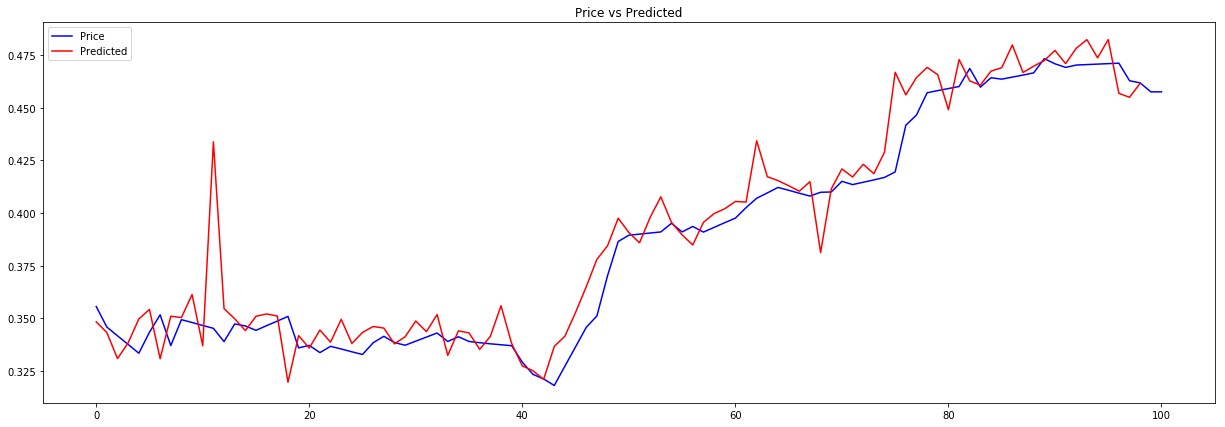

In [395]:
plt.figure(figsize=(21,7))
plt.plot(yTest,label='Price',color='blue')
plt.plot(test_pred_list,label='Predicted',color='red')
plt.title('Price vs Predicted')
plt.legend(loc='upper left')
plt.show()

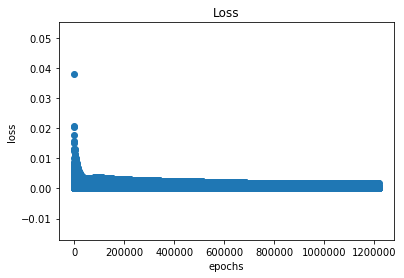

In [397]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Loss')
plt.scatter(x=np.arange(0,len(loss_list)), y=loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()